In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Importing the RNN class and task dataset implementation
from train_rnn import MyRNN, train, simulate_with_lesions
from rnntaskdataset import RNNTaskDataset

# Define the hyperparameter search space
hidden_dims = [16, 32, 64, 128, 256, 512]
initialization_types = ['random']
g_values = [0.1, 0.5, 0.9]
nonlinearities = ['tanh','relu']
tasks = ['ready_set_go', 'delay_discrimination', 'flip_flop', 'integrator']
device='cpu'

import torch.nn as nn
class MaskedMSELoss(nn.Module):
    def __init__(self):
        super(MaskedMSELoss, self).__init__()

    def forward(self, y_pred, y_true):
        # Create a mask that is 1 where y_true is not nan and 0 where y_true is nan
        mask = ~torch.isnan(y_true)

        # Apply the mask to y_pred and y_true
        y_pred_masked = y_pred[mask]
        y_true_masked = y_true[mask]

        # Compute MSE only for non-nan values
        loss1 = nn.functional.mse_loss(y_pred_masked, y_true_masked)
        loss2 = torch.mean((y_pred_masked-y_true_masked)**2)
        std = torch.std((y_pred_masked-y_true_masked)**2)
        all_loss = (y_pred_masked-y_true_masked)**2
        
        return loss1, loss2, std, all_loss

criterion_fn = MaskedMSELoss()

In [2]:
plot = True
low = True
percentage_silenced=0.1

dic = {
    'hidden':[],
    'g':[],
    'phi':[],
    'task':[],

    'connectivity_std':[],
    'activity_std':[],
    
    'mse_control':[],
    'std_control':[],

    'mse_lesion_connectivity':[],
    'std_lesion_connectivity':[],

    'mse_lesion_activity':[],
    'std_lesion_activity':[],

}

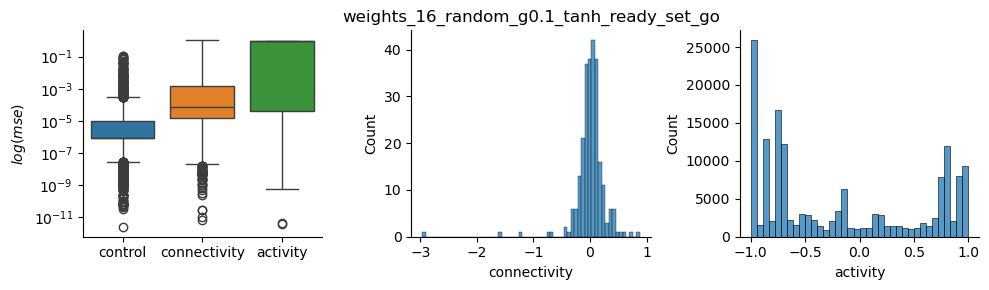

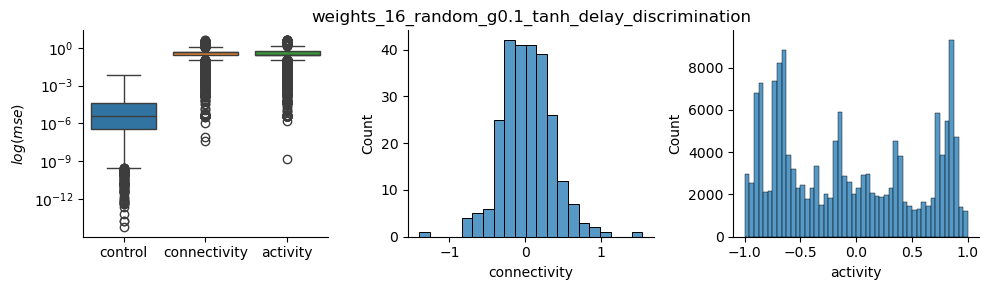

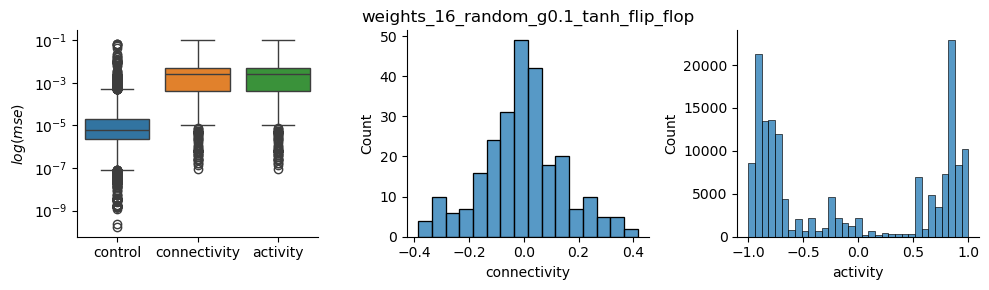

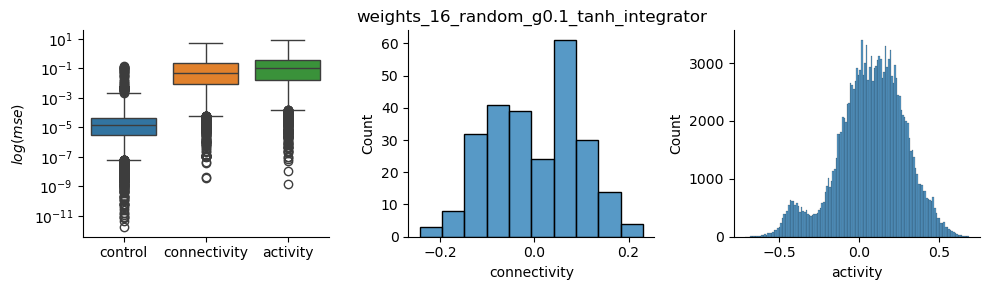

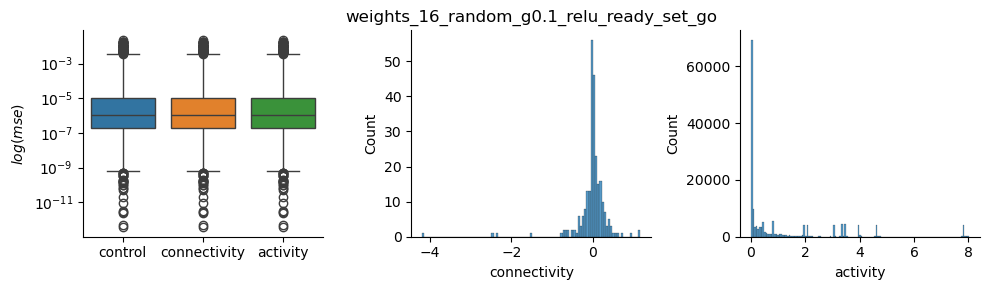

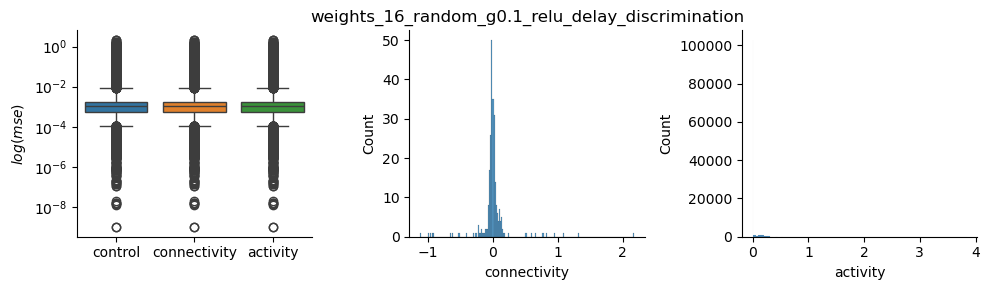

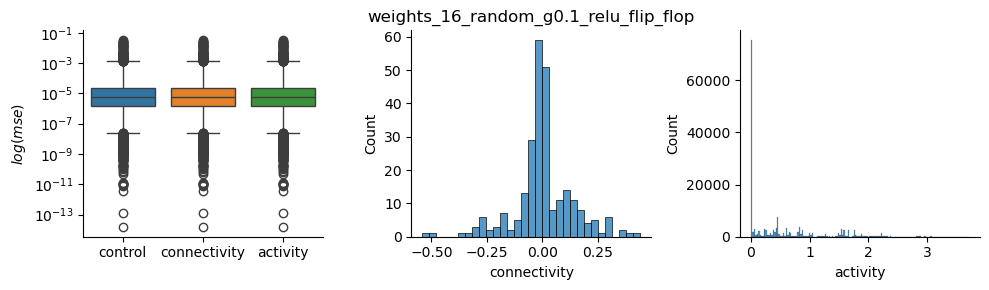

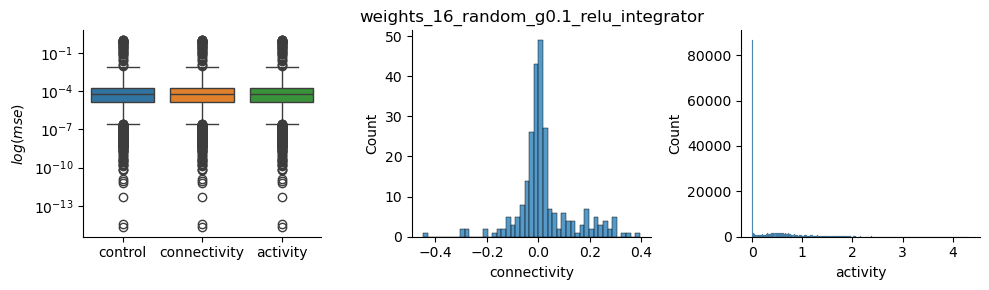

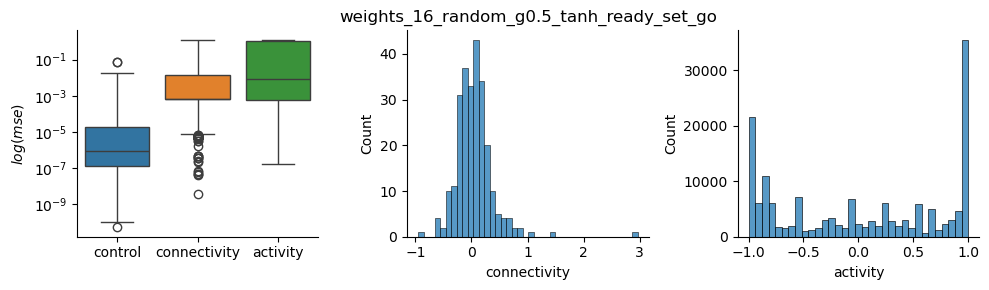

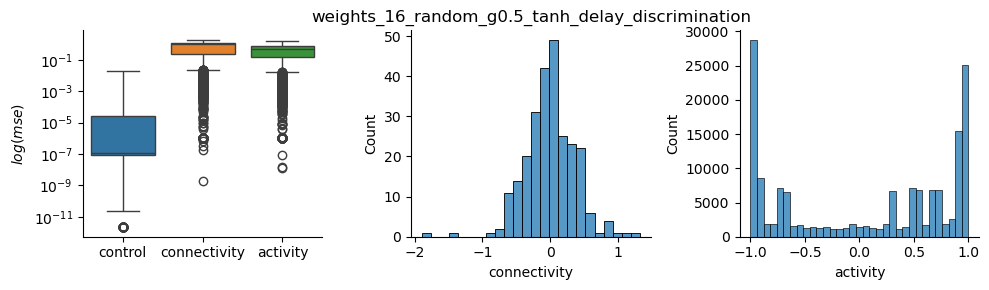

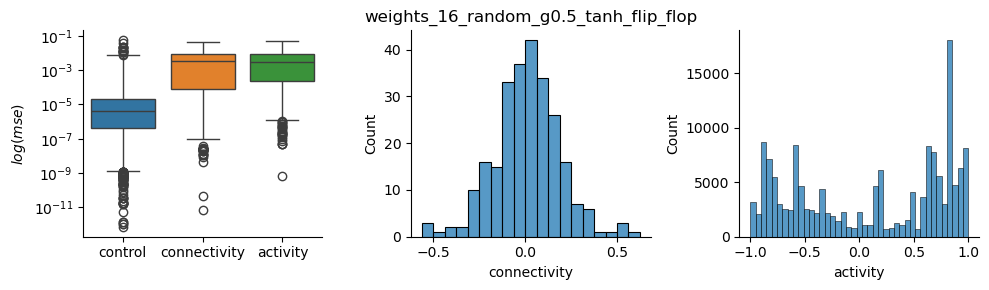

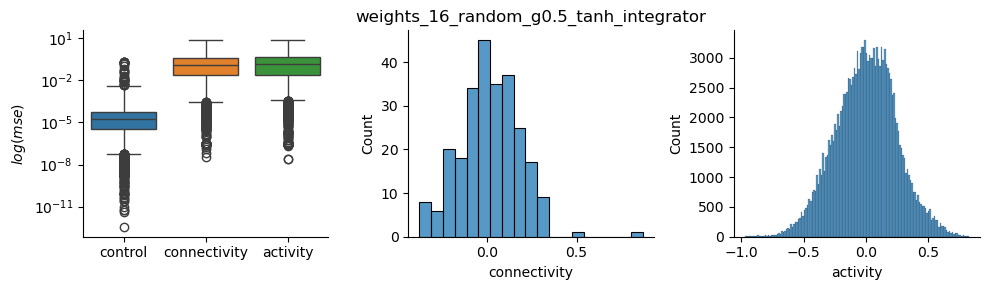

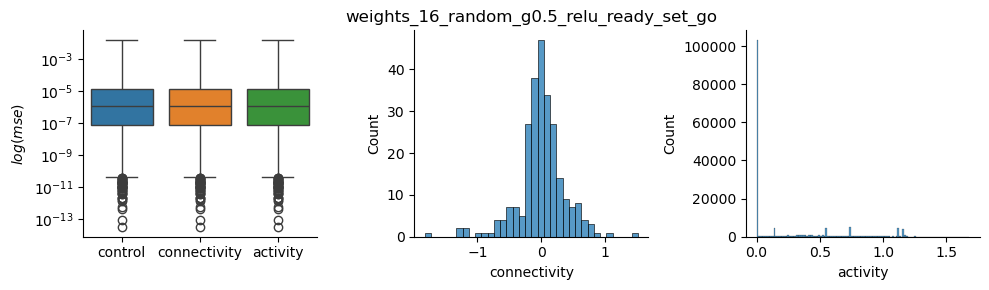

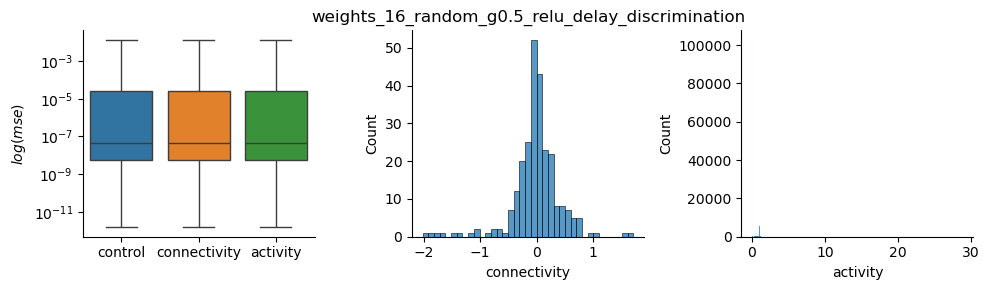

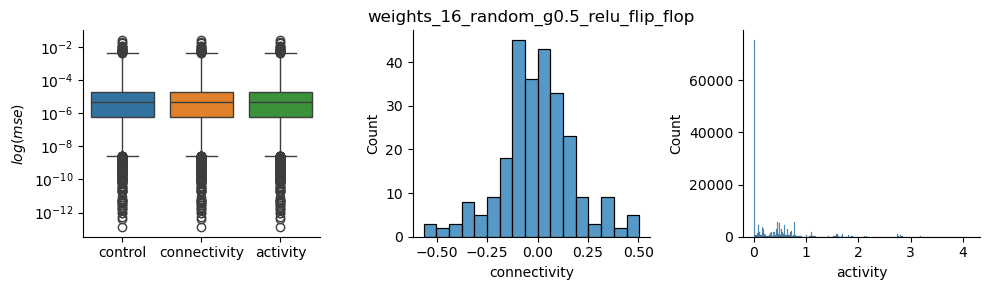

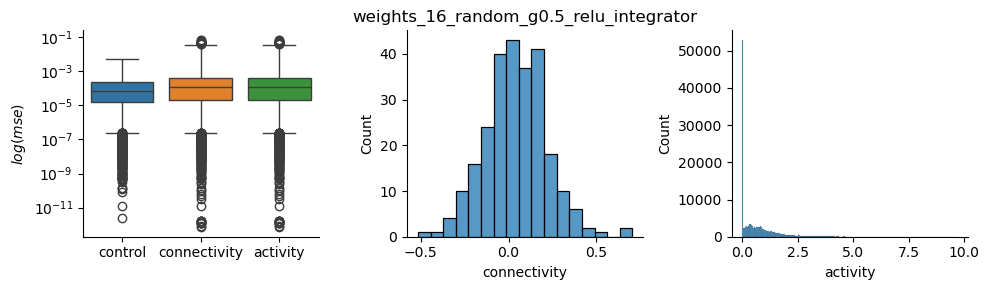

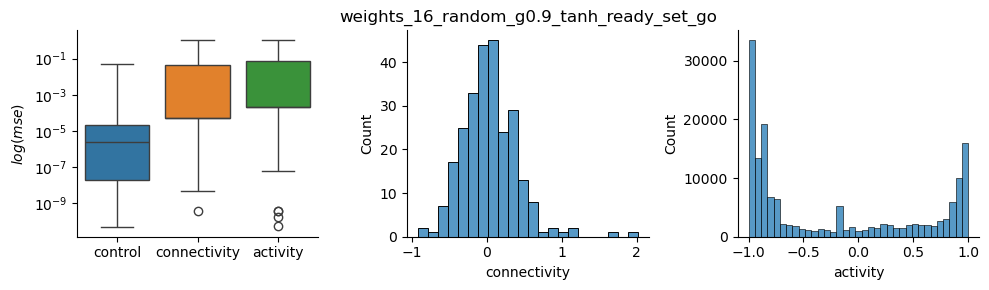

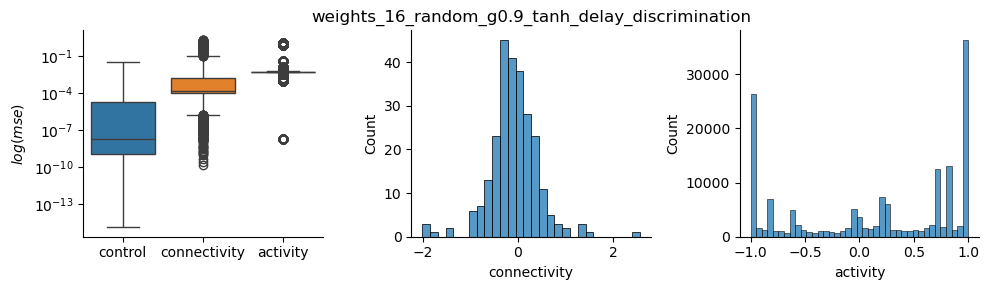

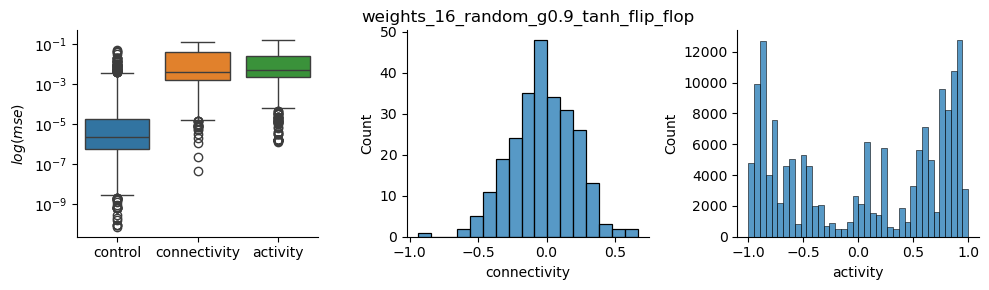

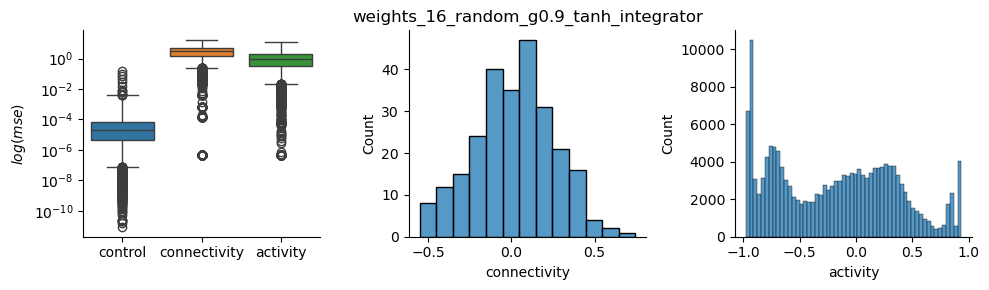

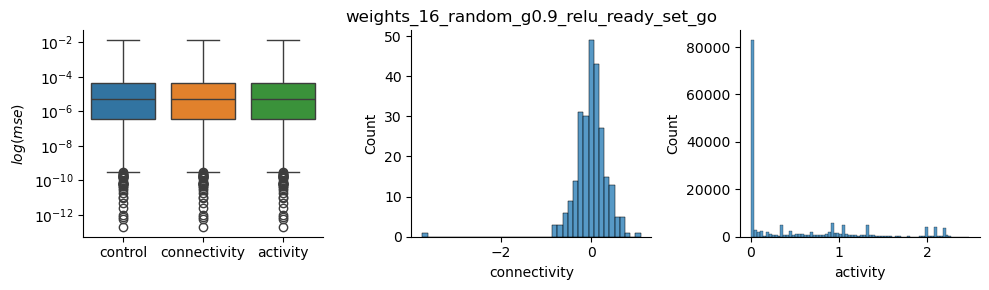

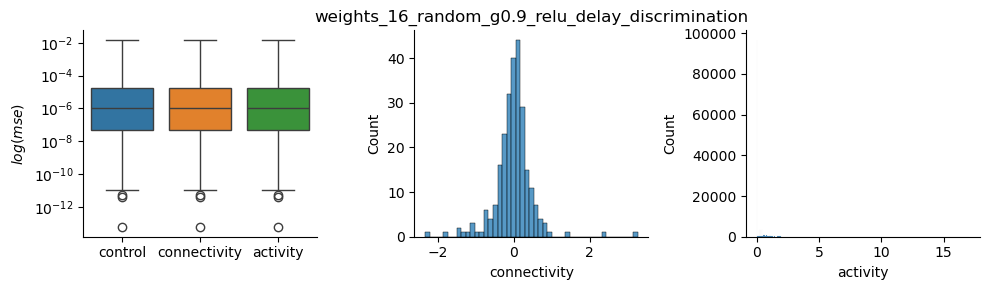

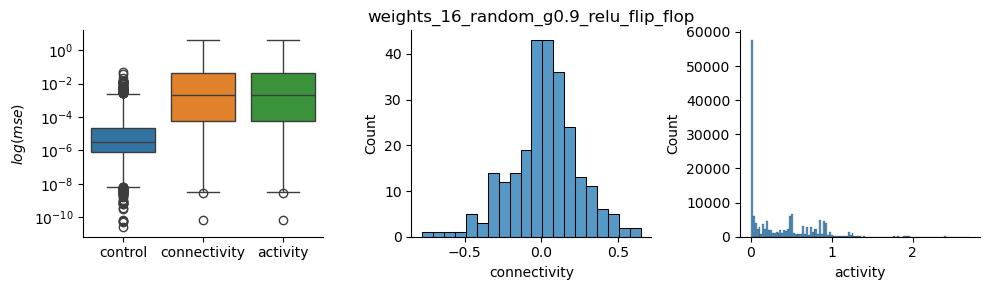

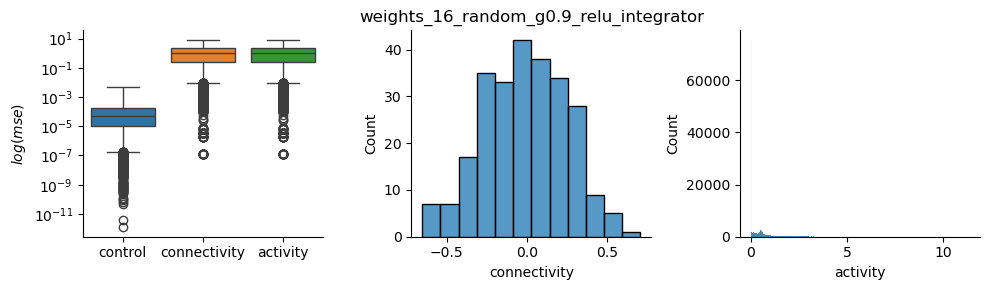

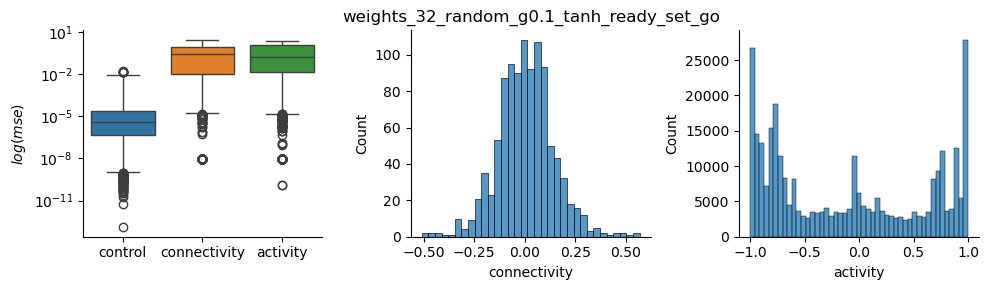

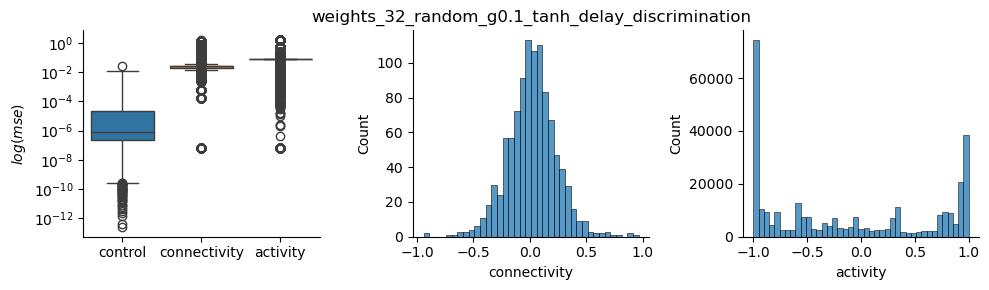

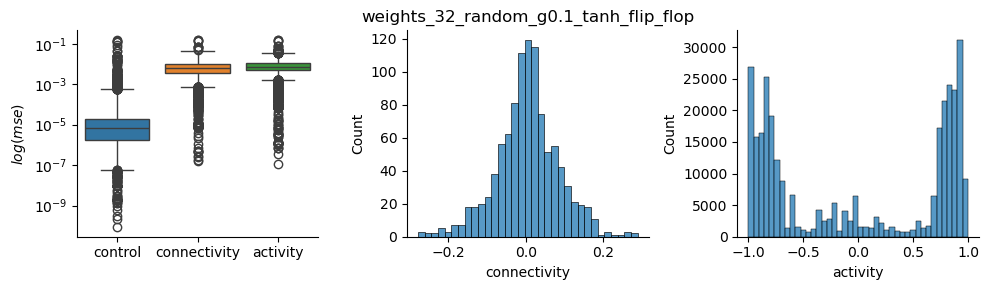

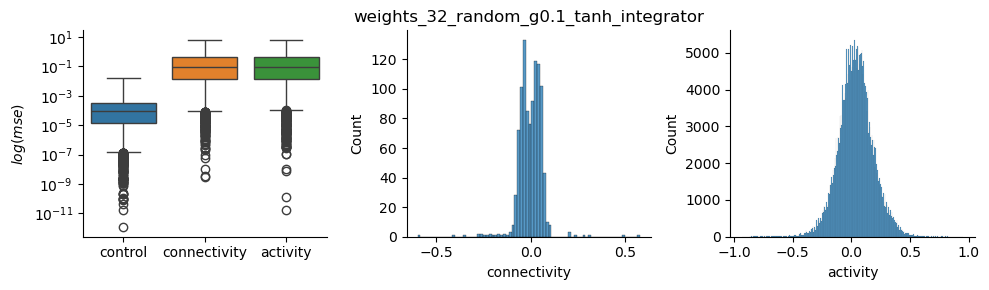

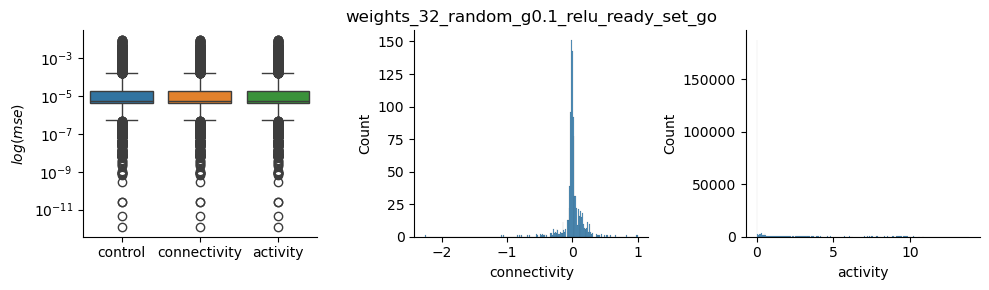

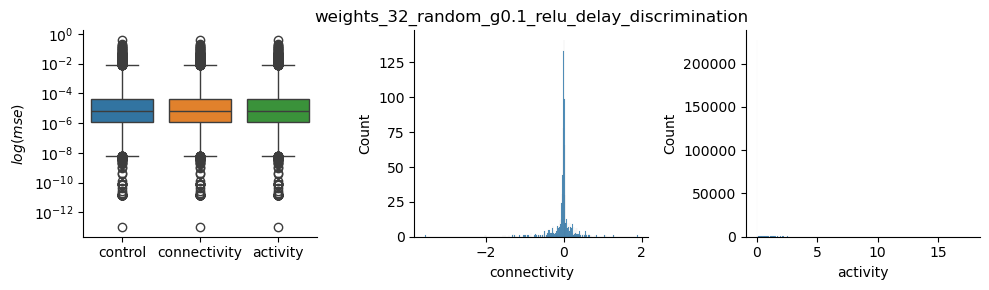

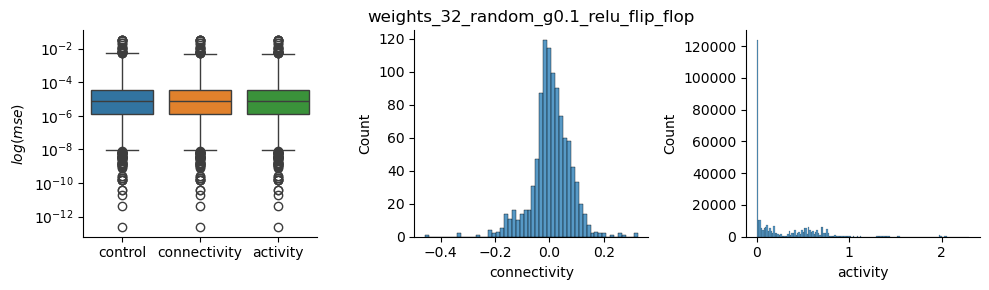

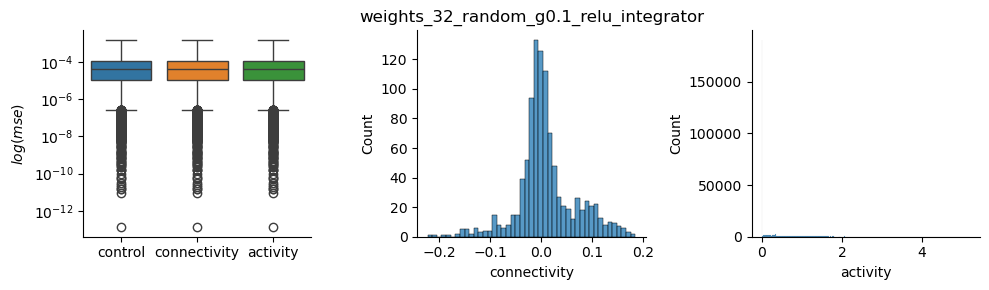

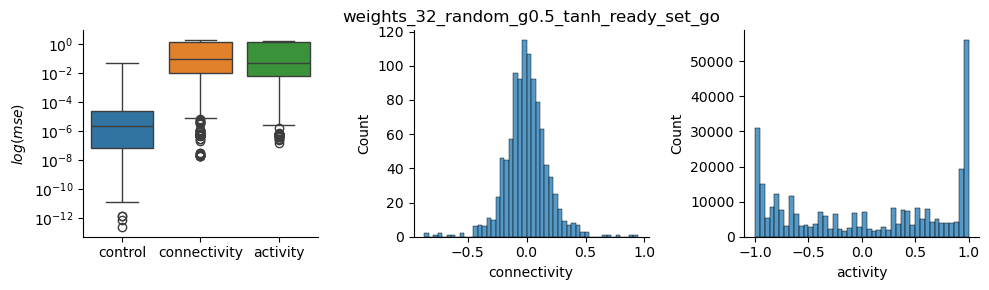

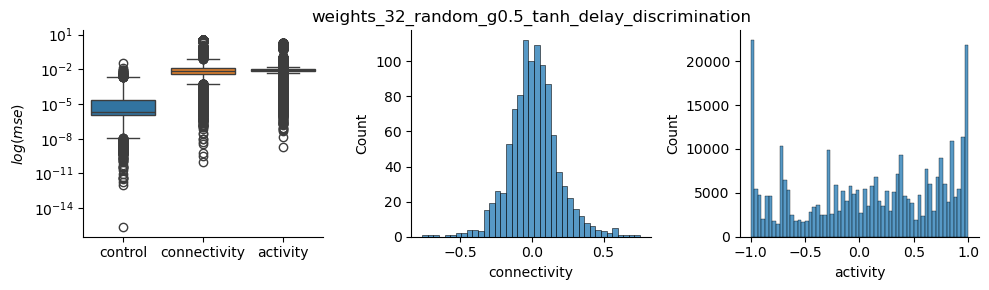

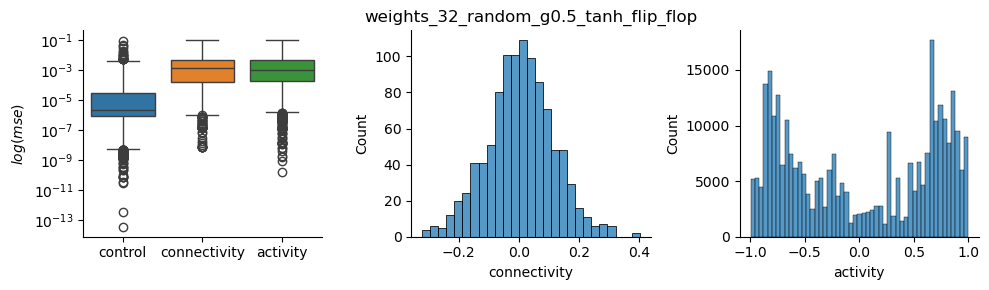

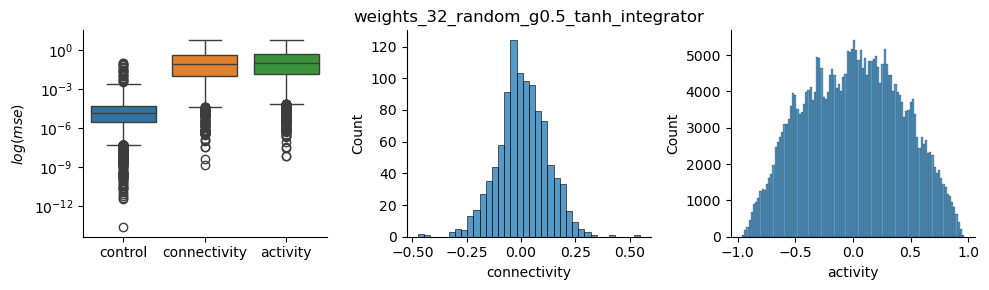

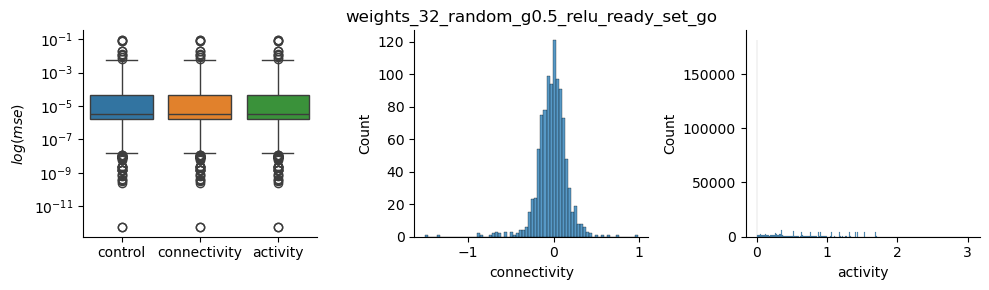

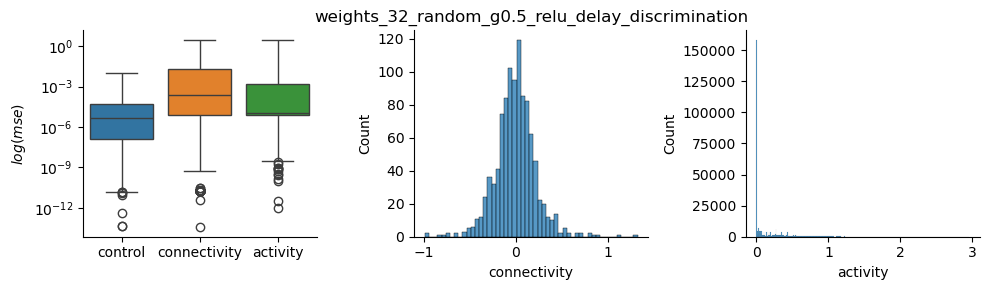

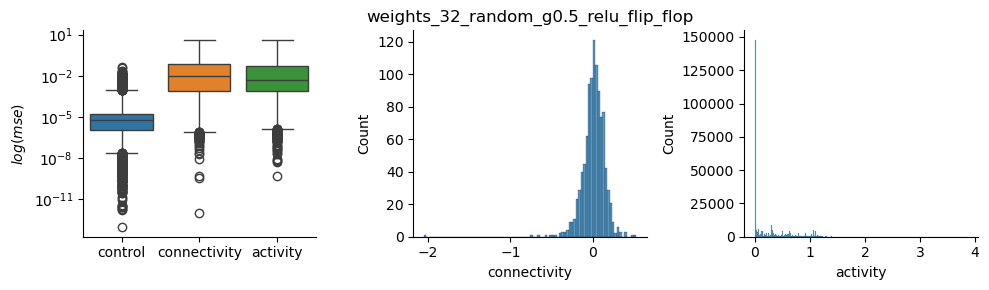

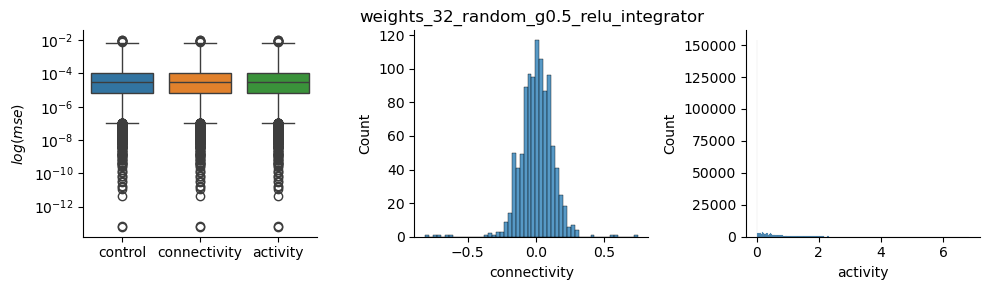

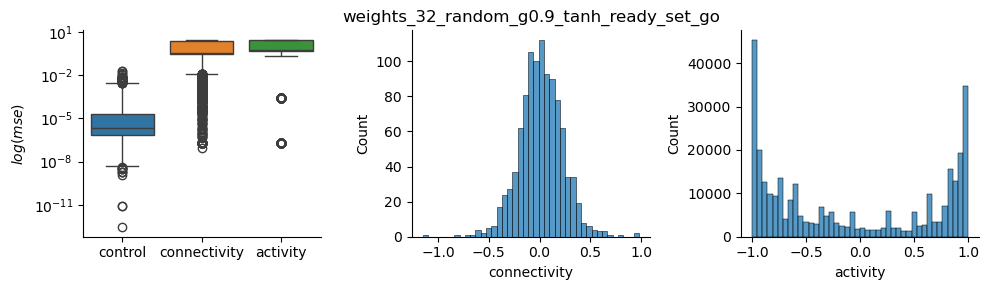

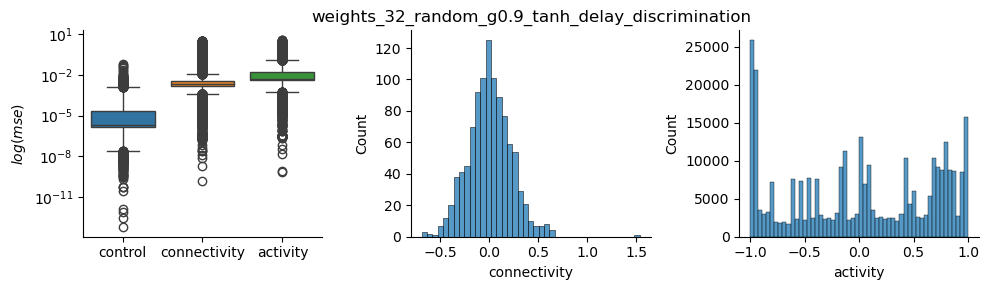

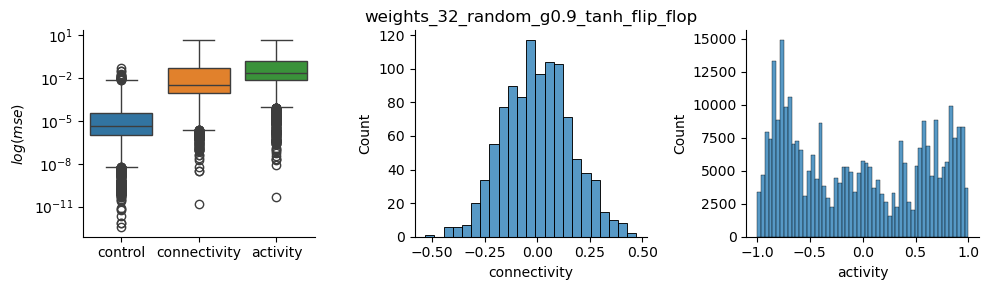

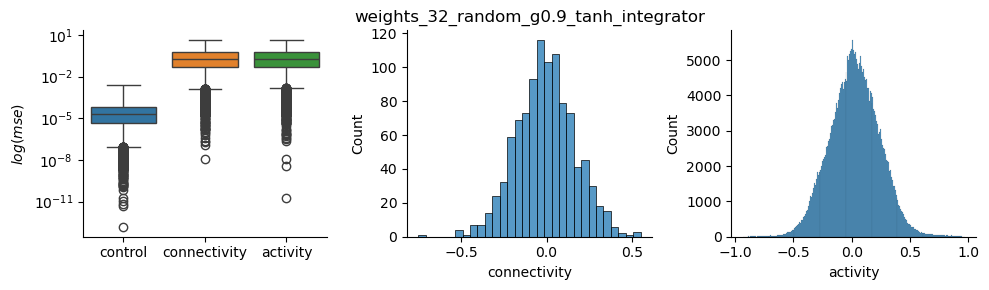

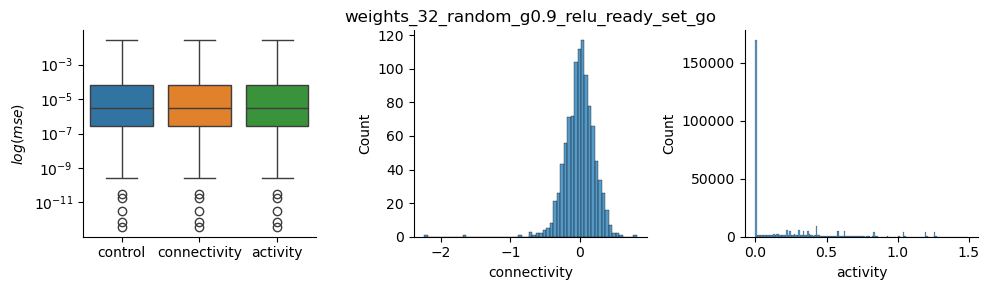

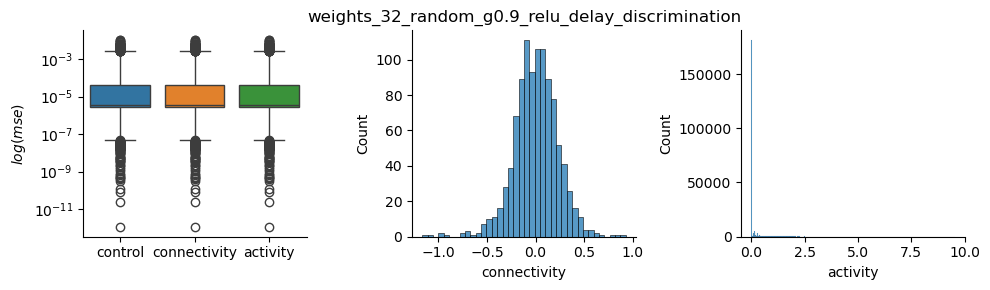

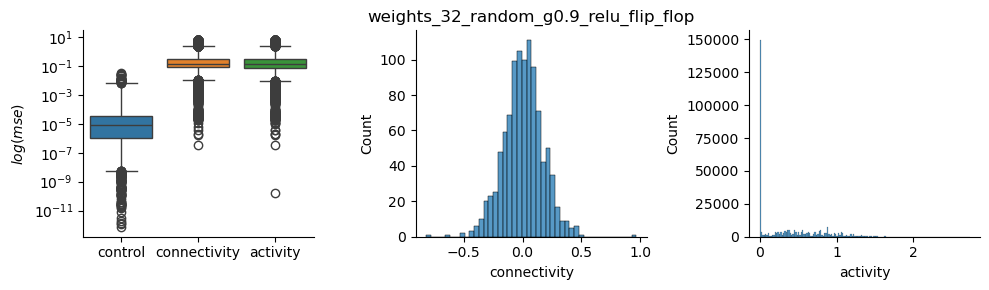

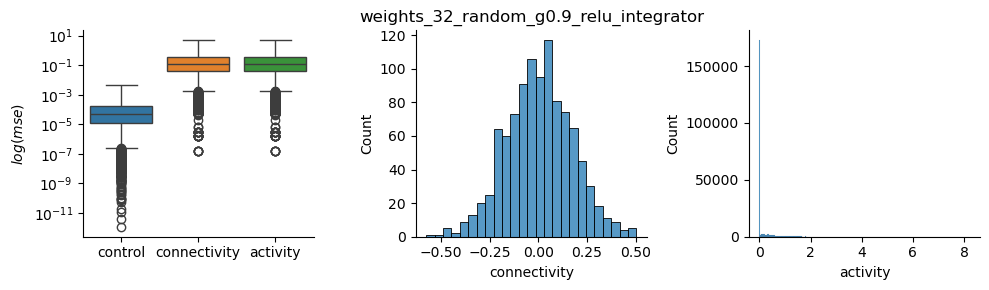

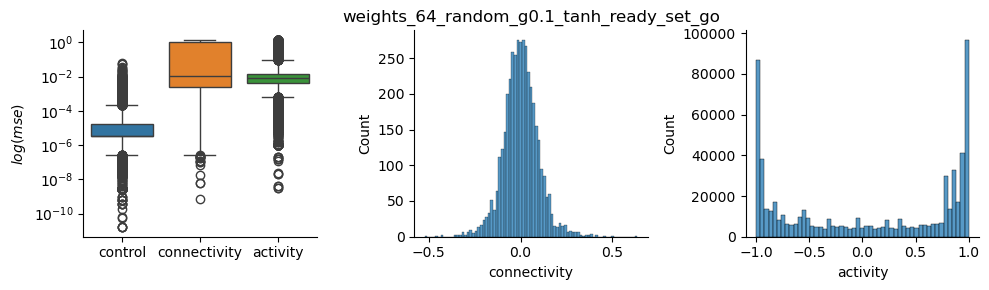

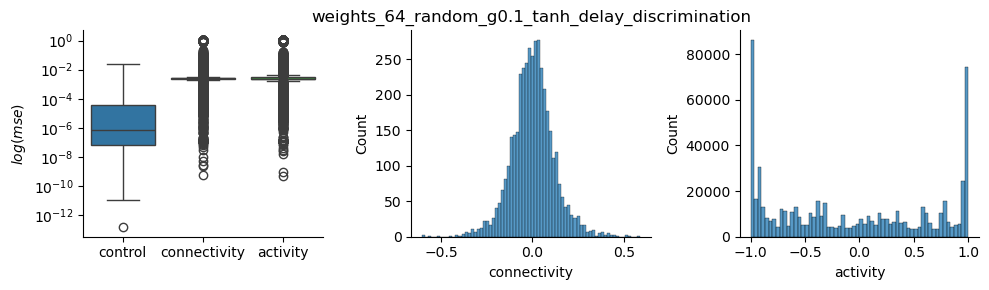

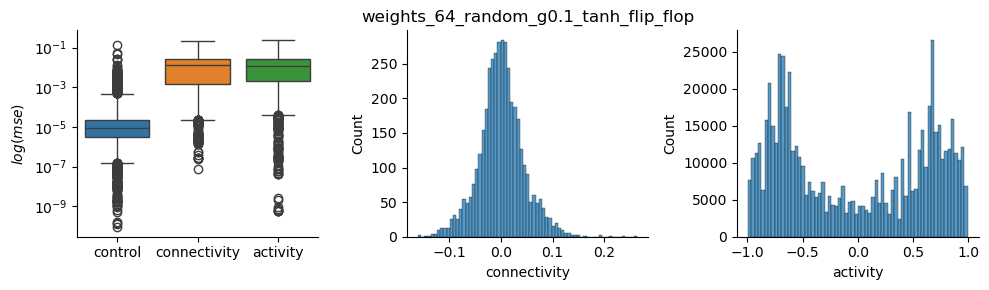

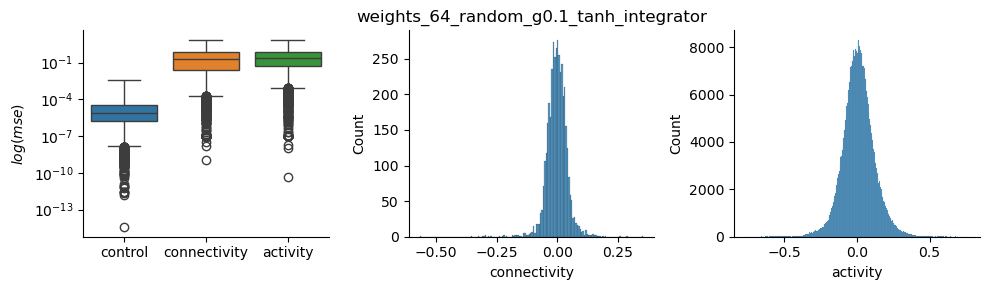

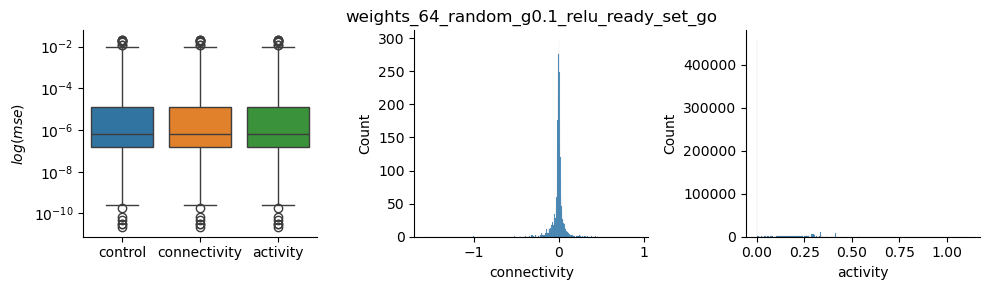

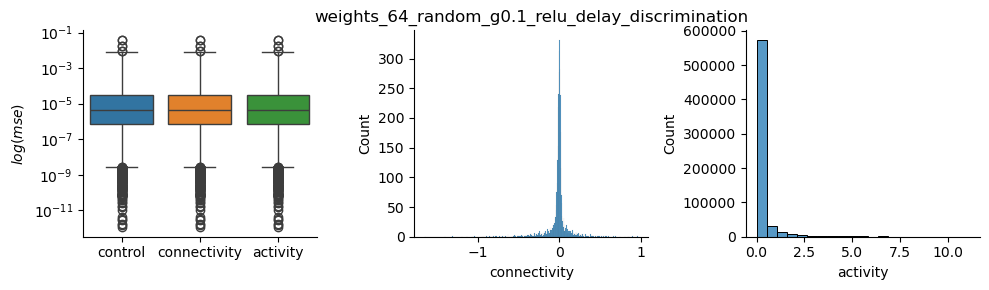

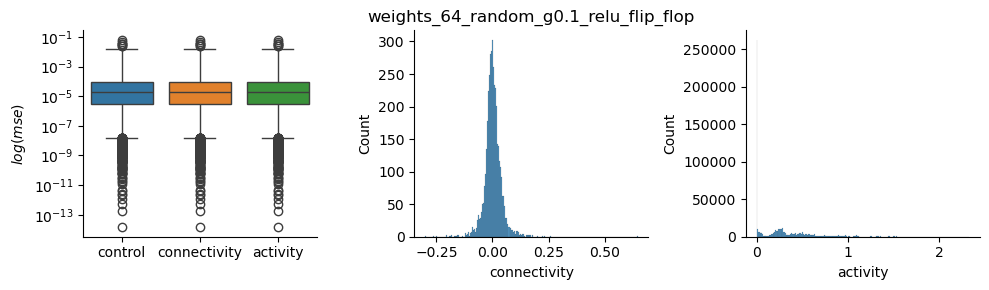

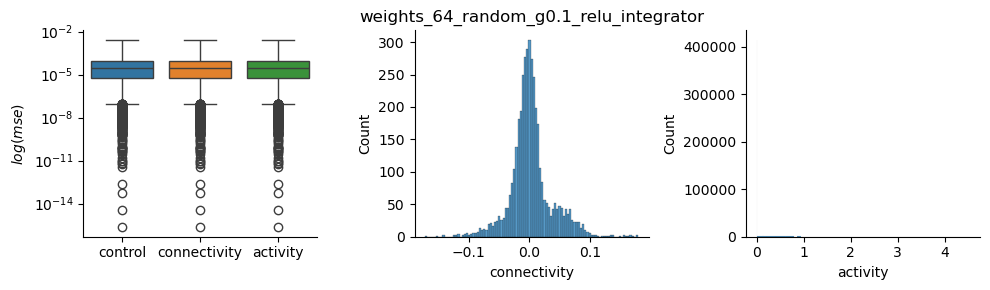

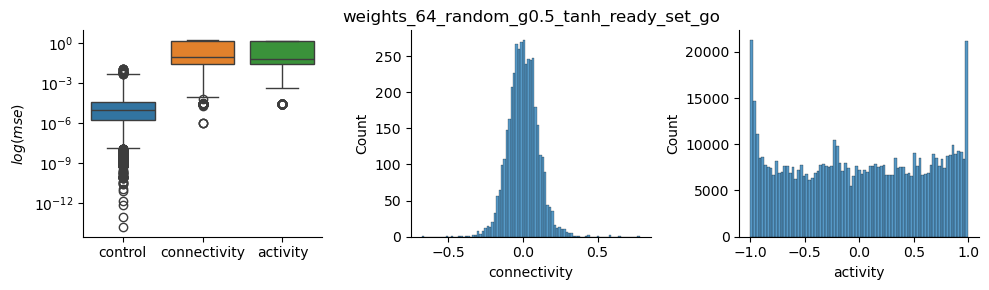

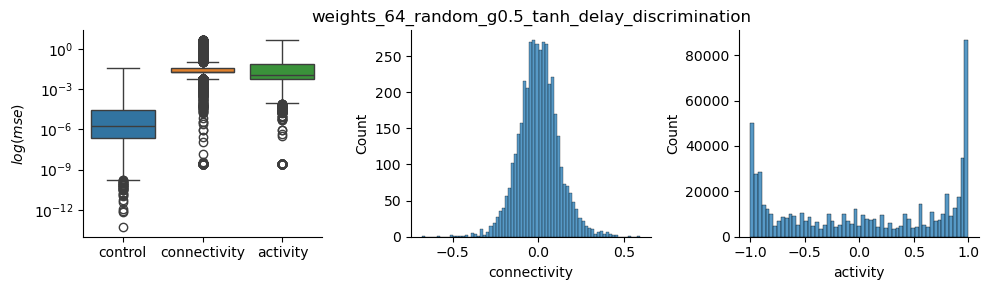

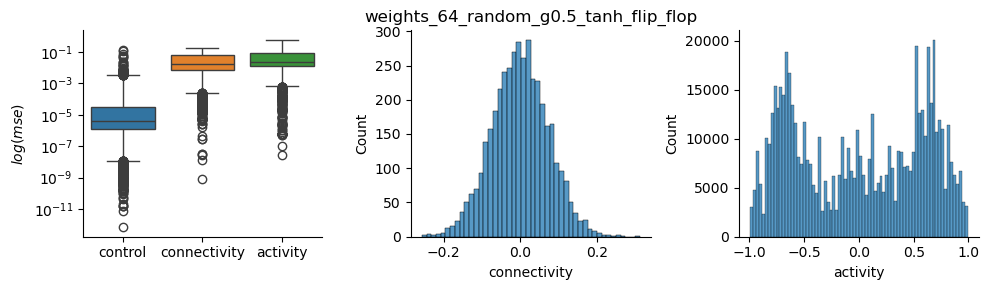

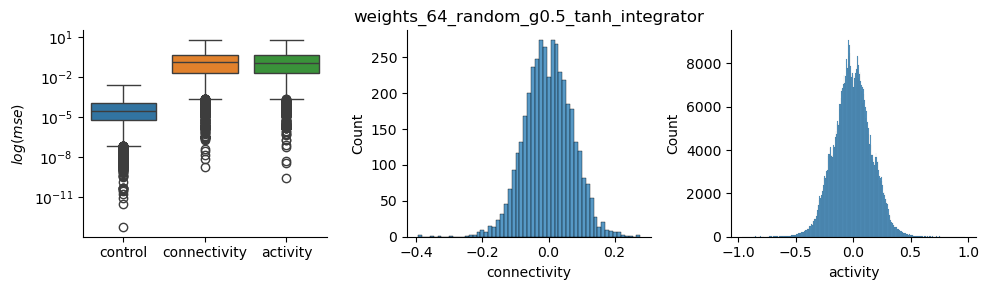

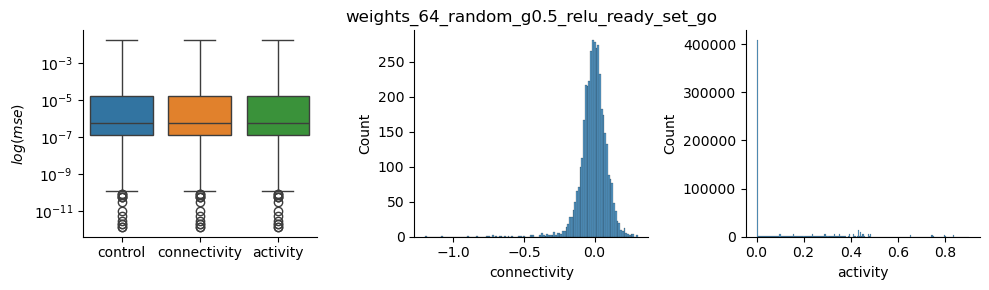

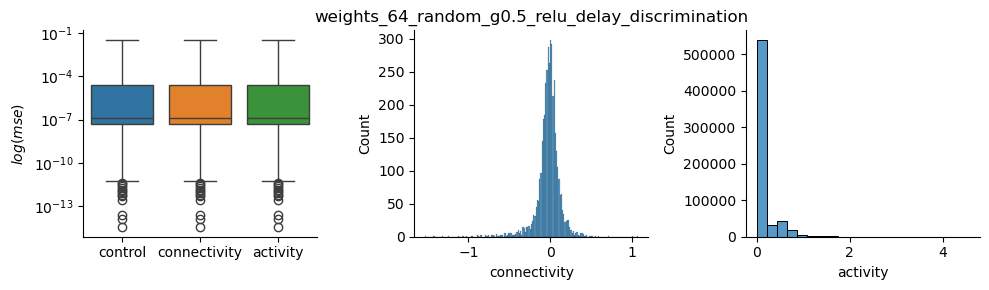

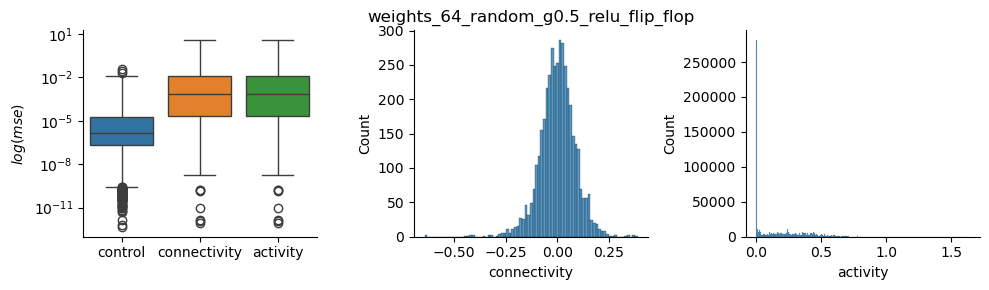

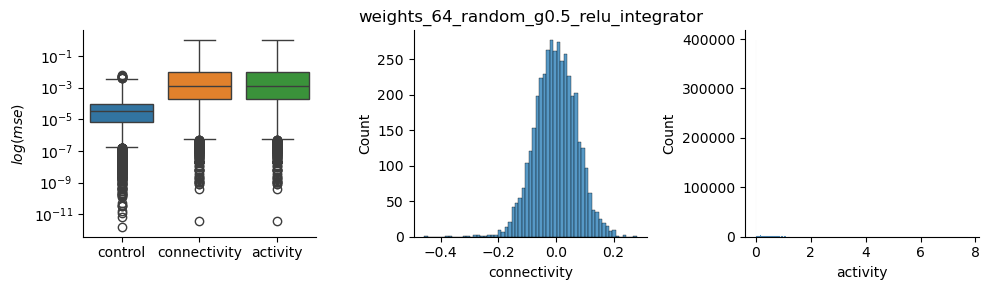

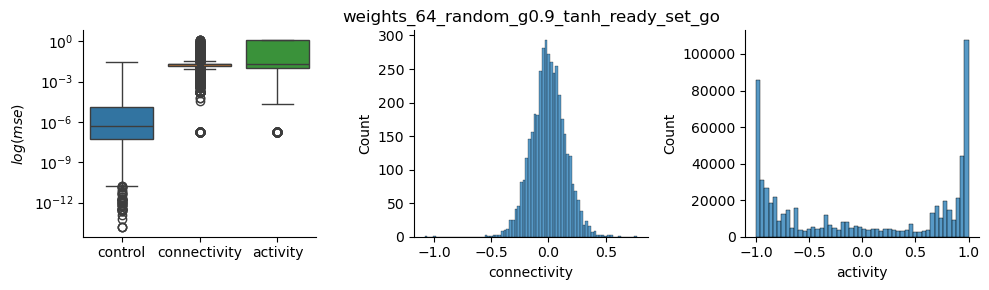

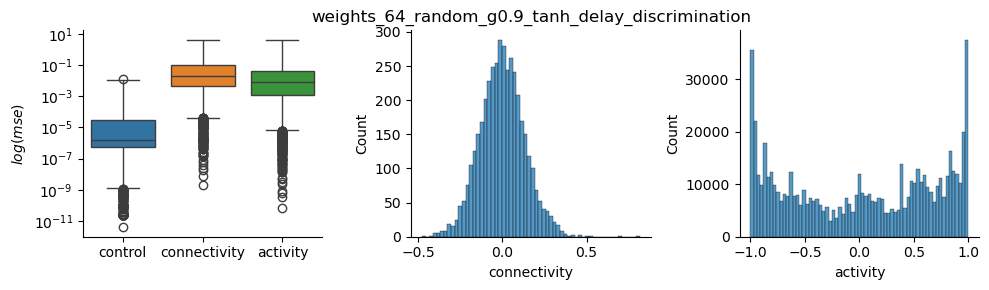

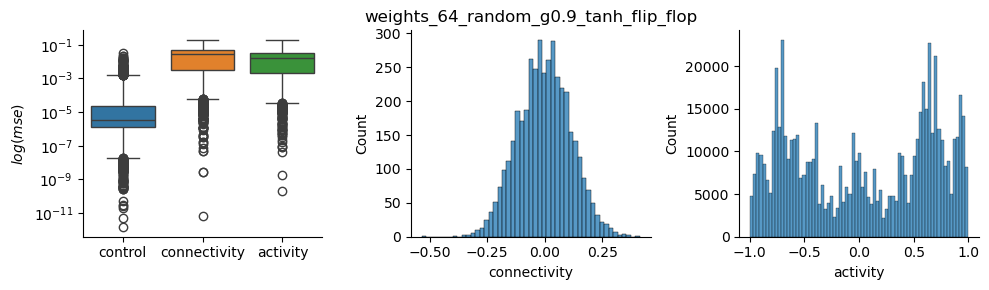

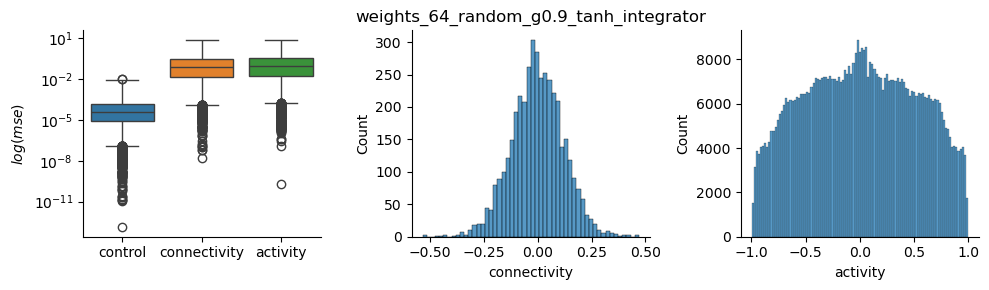

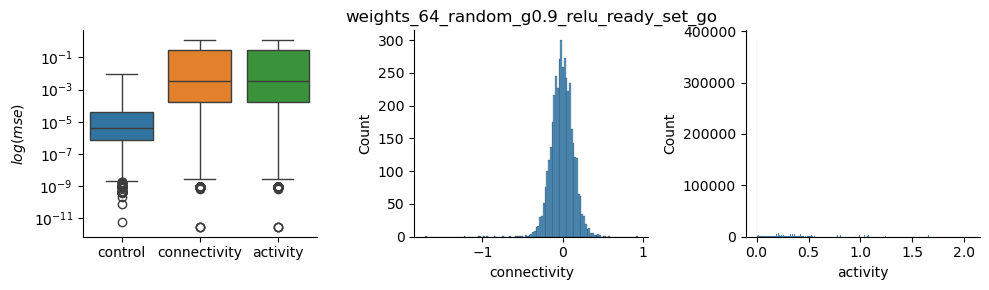

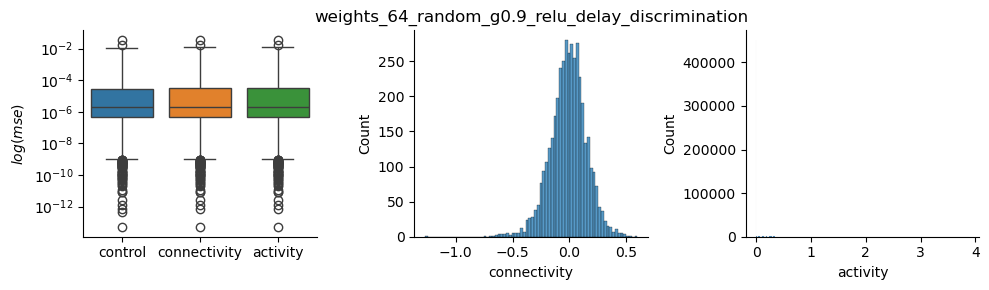

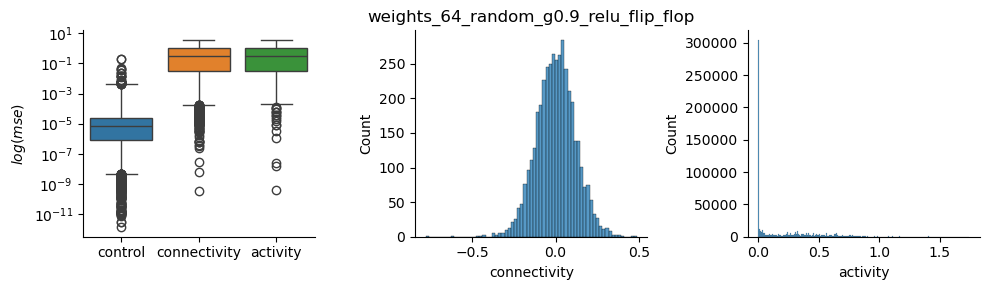

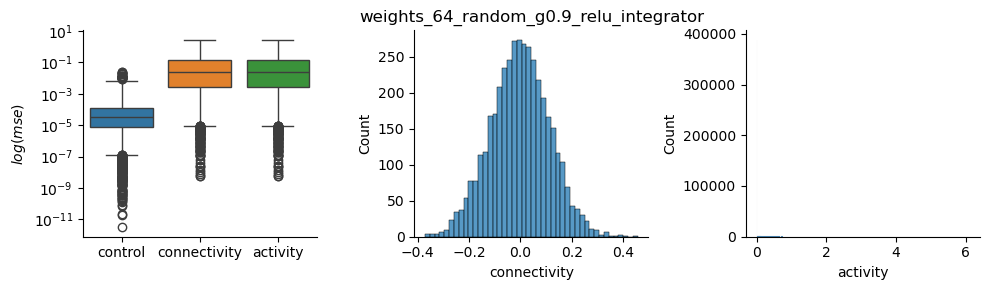

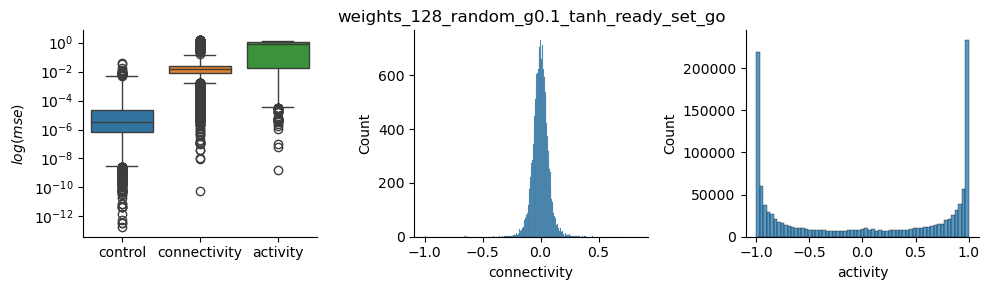

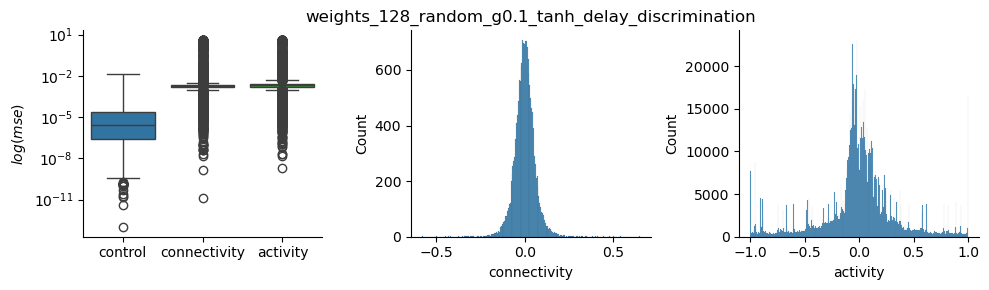

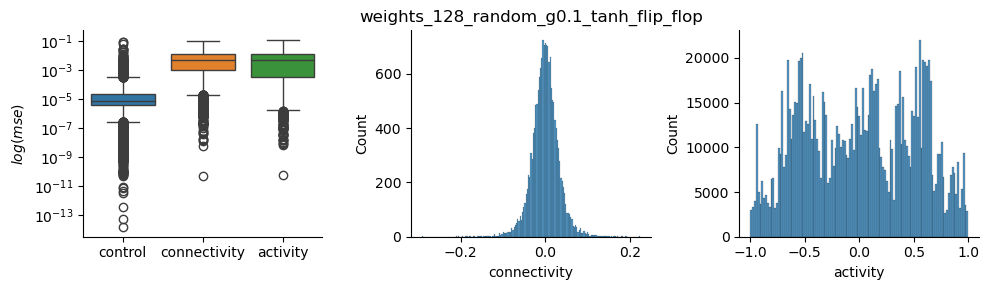

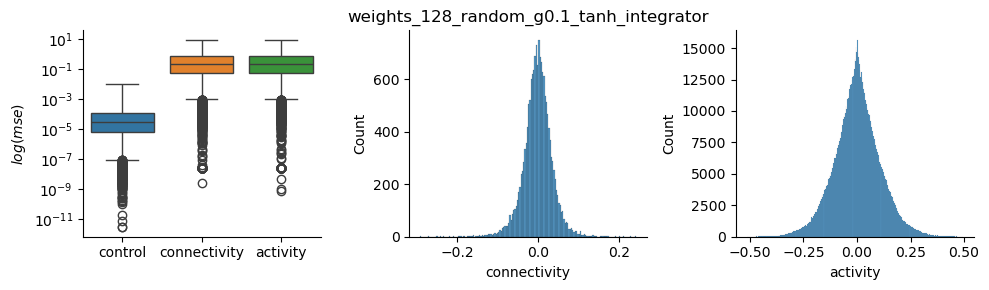

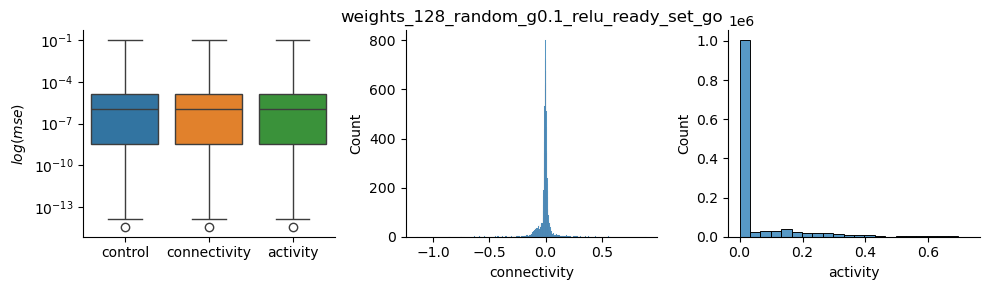

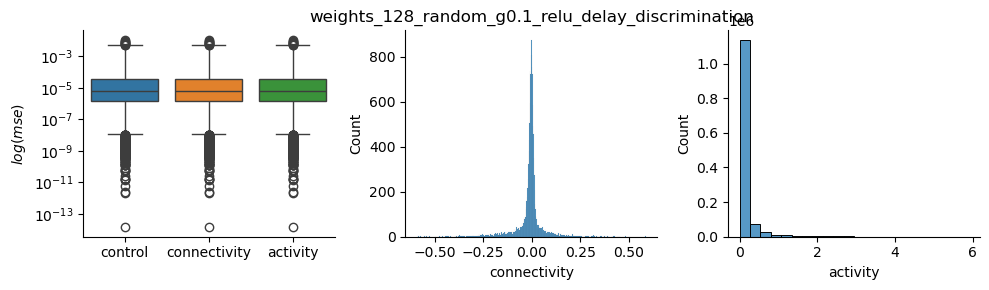

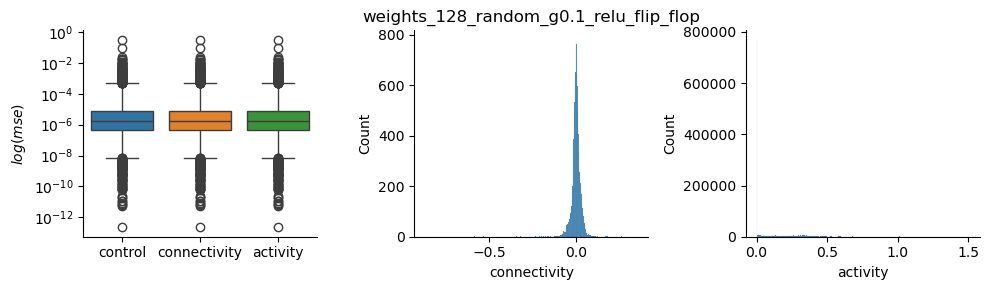

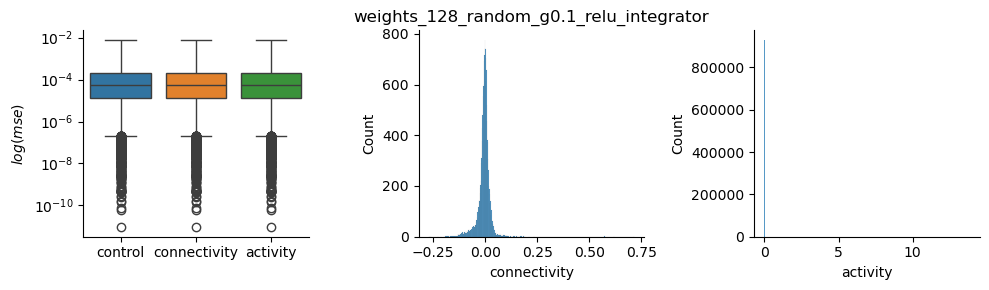

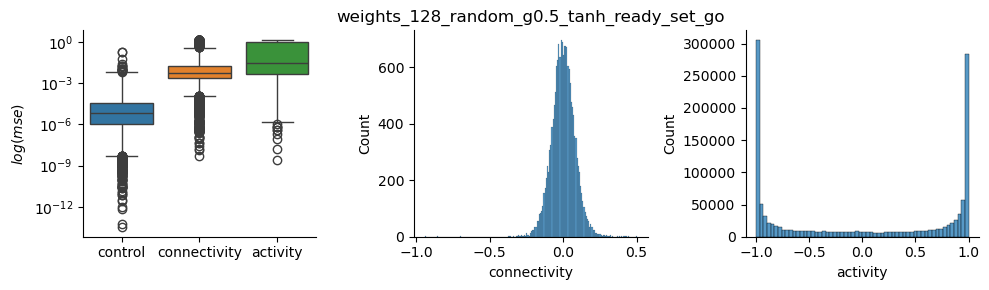

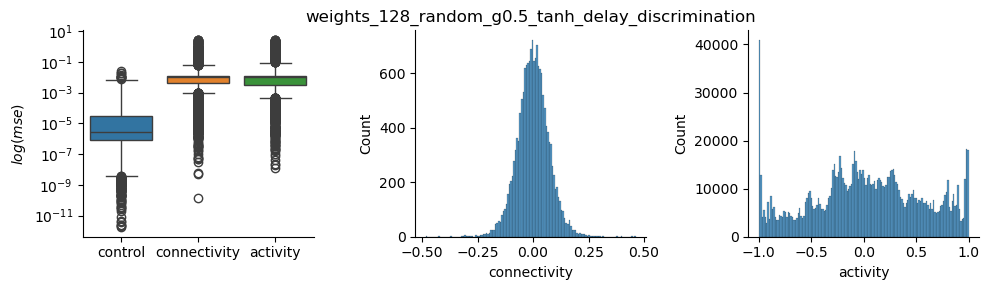

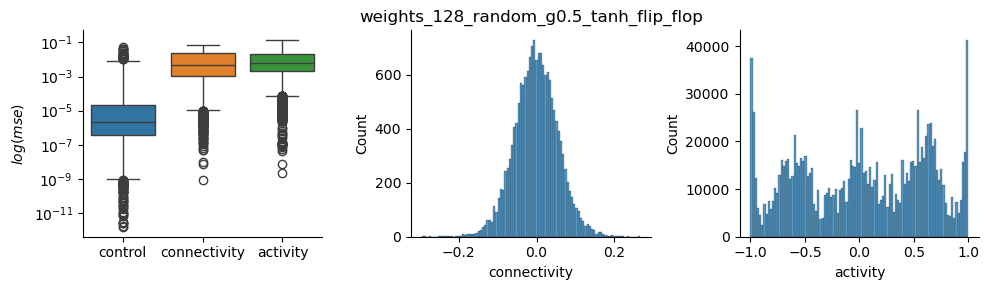

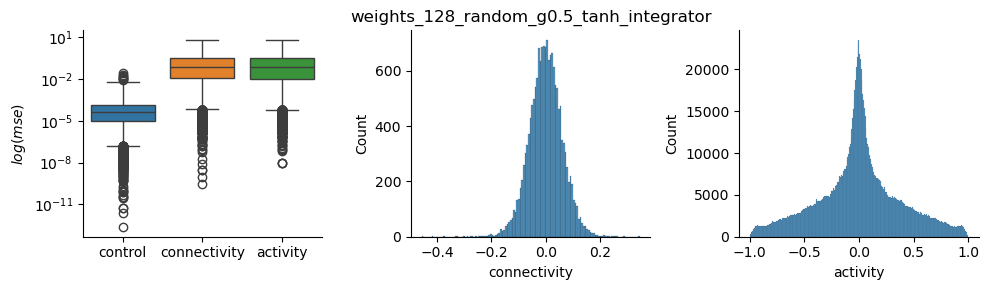

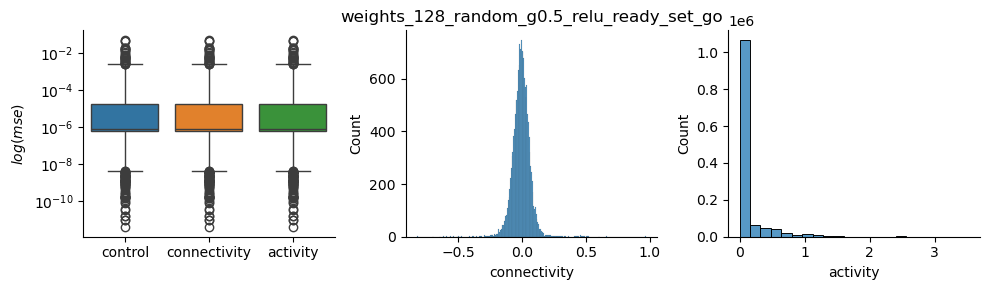

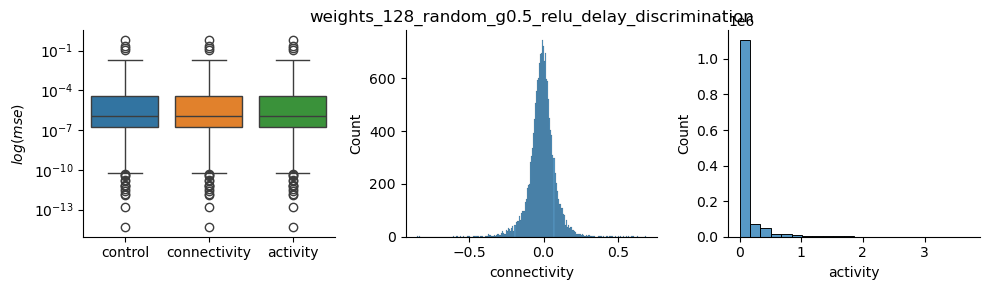

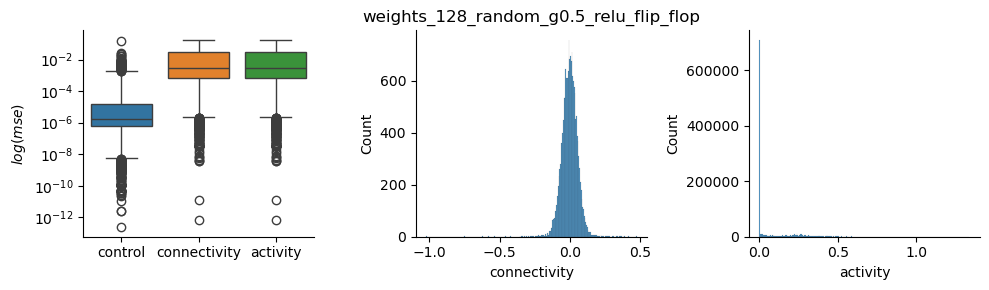

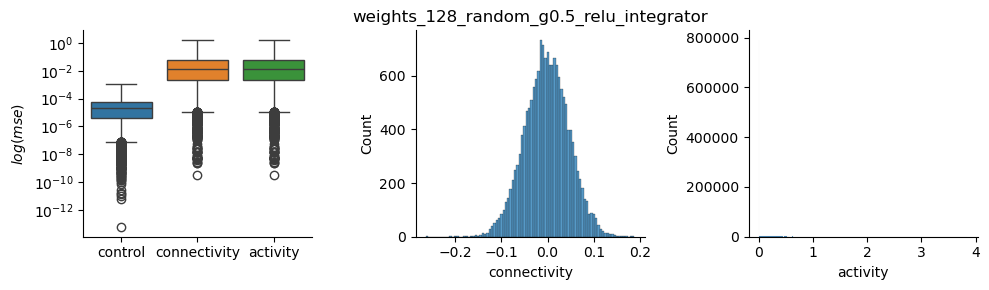

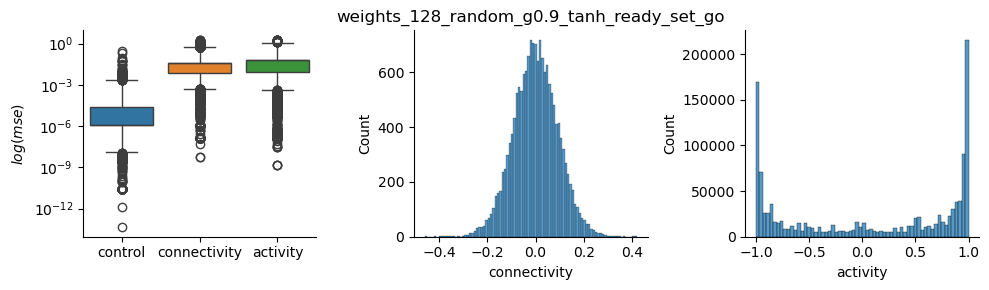

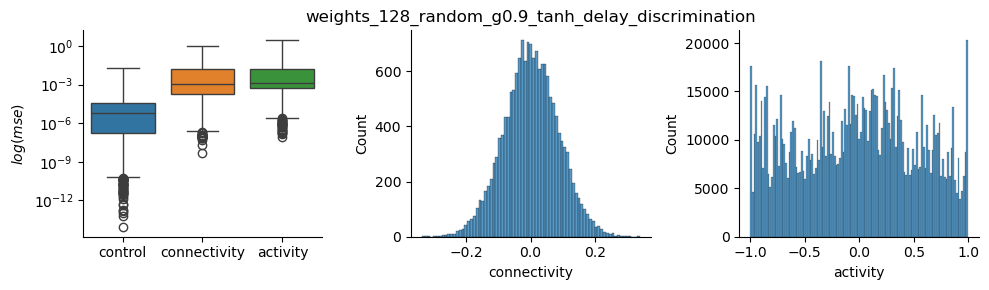

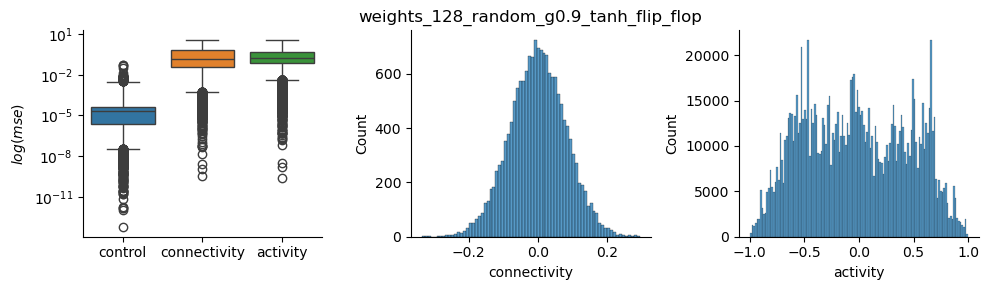

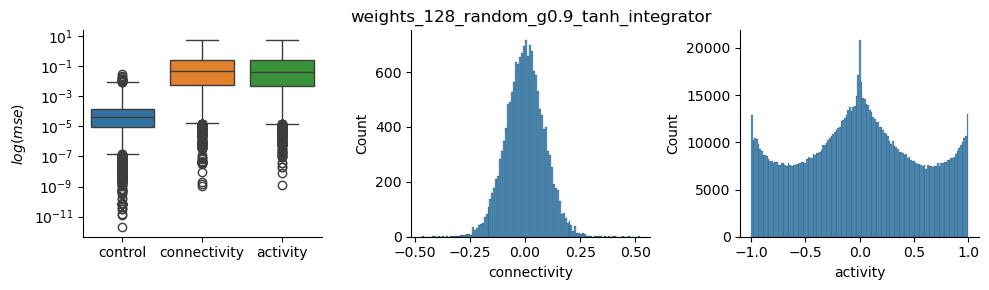

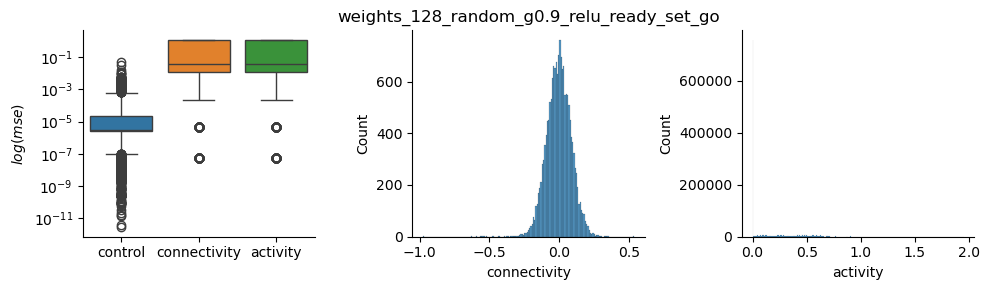

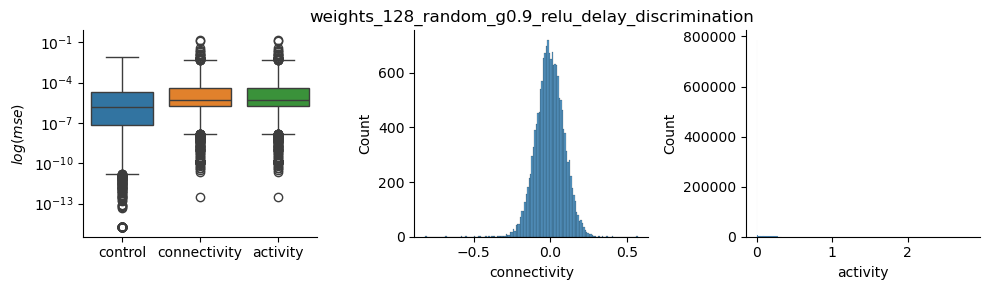

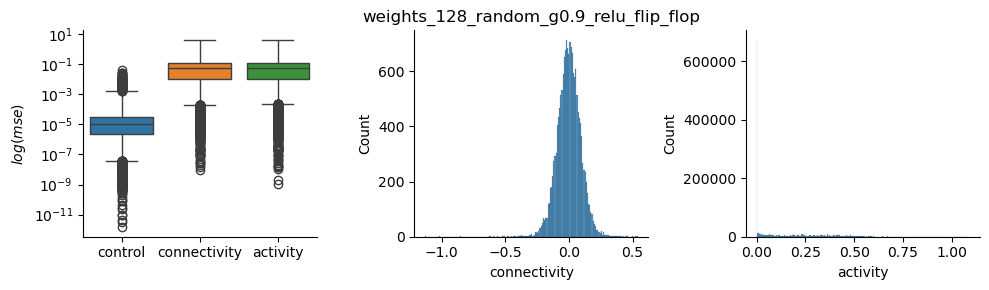

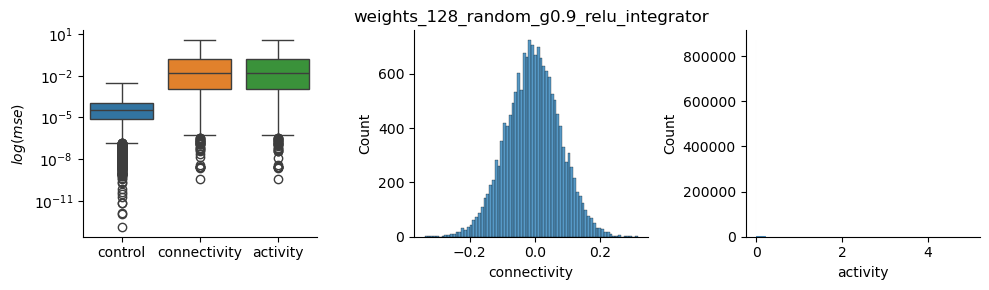

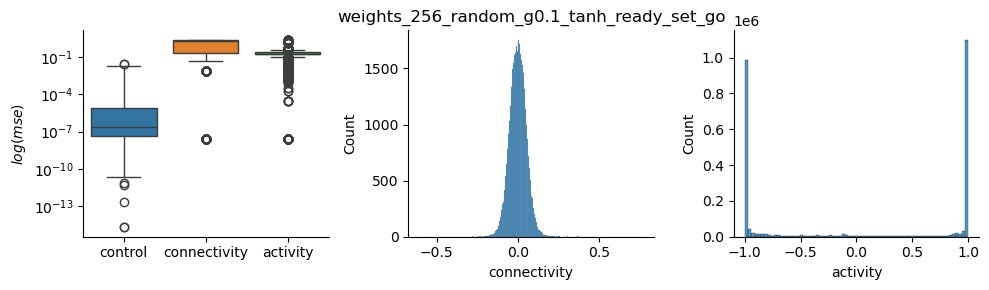

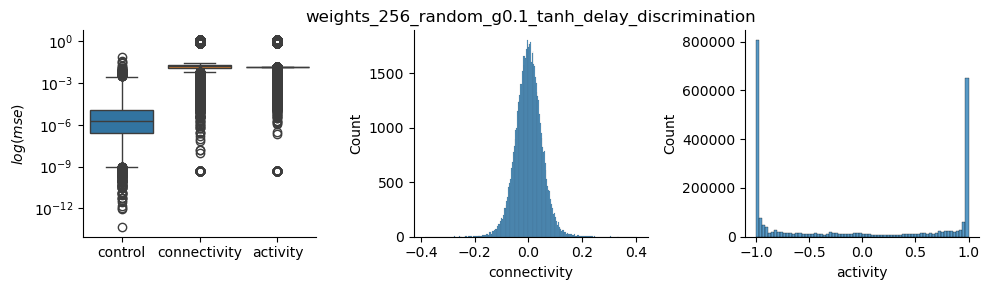

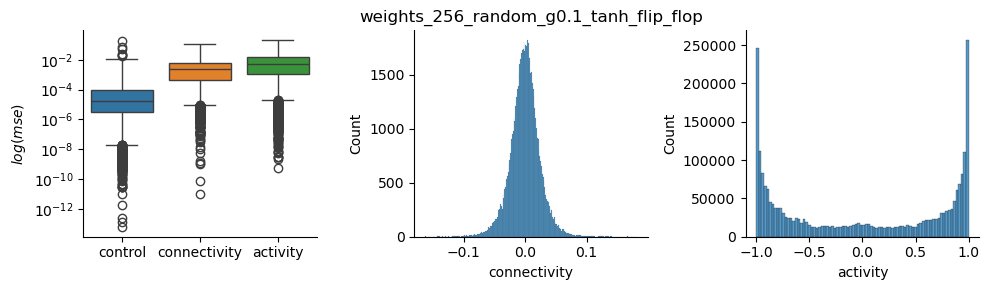

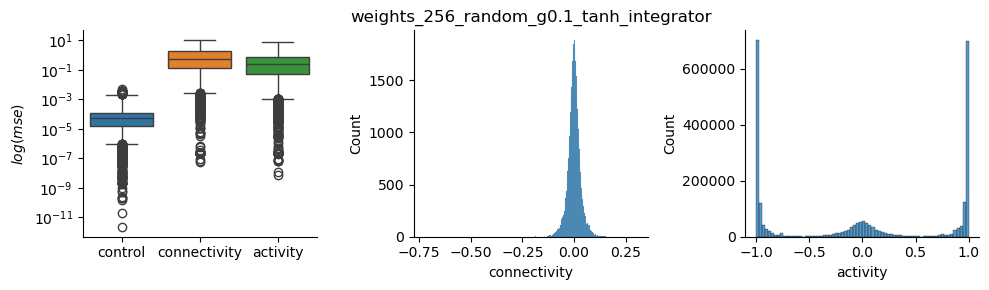

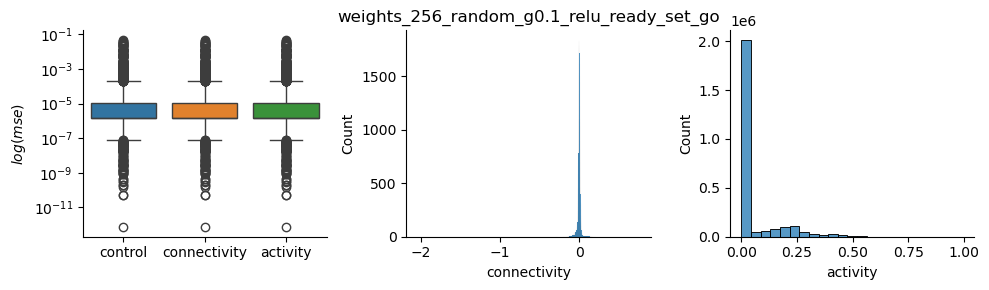

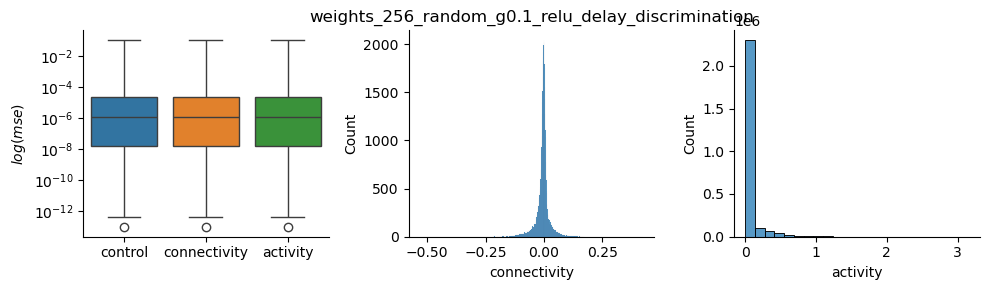

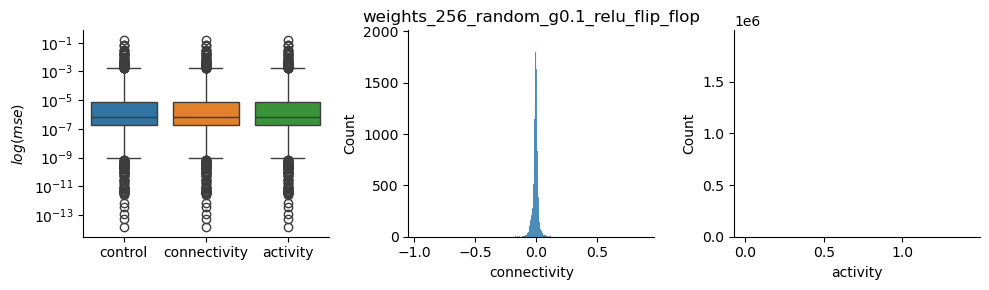

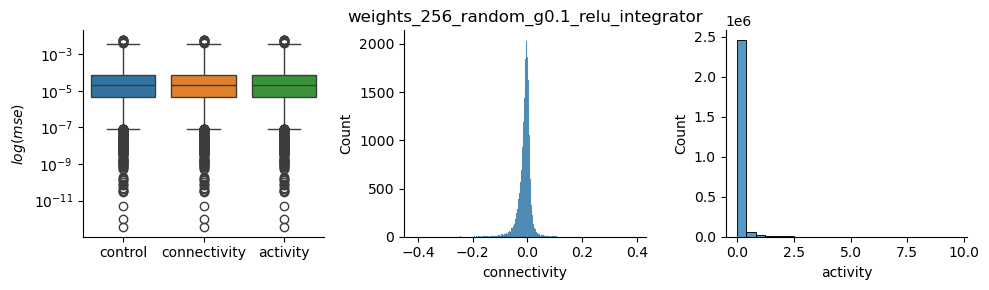

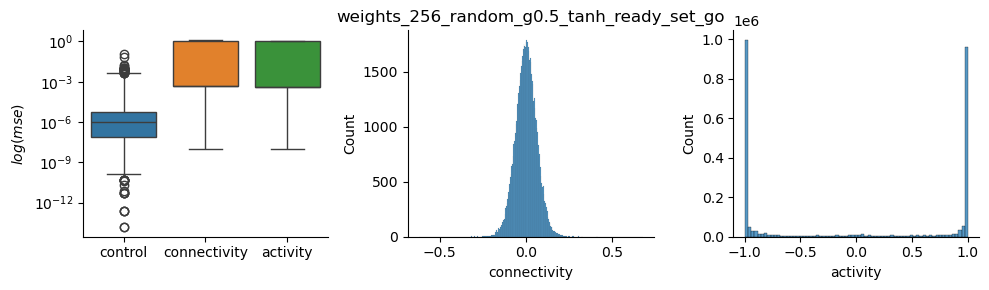

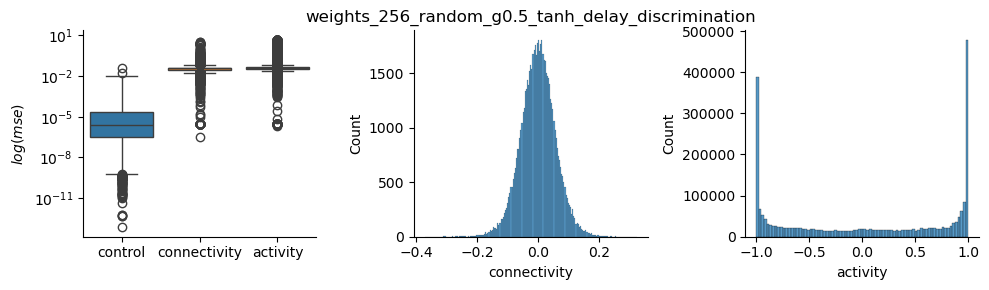

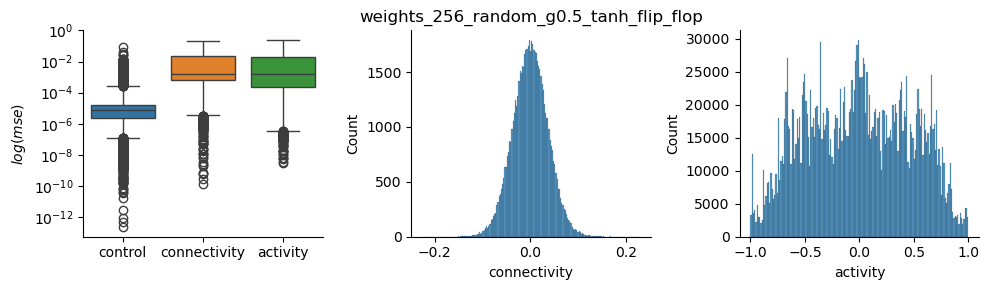

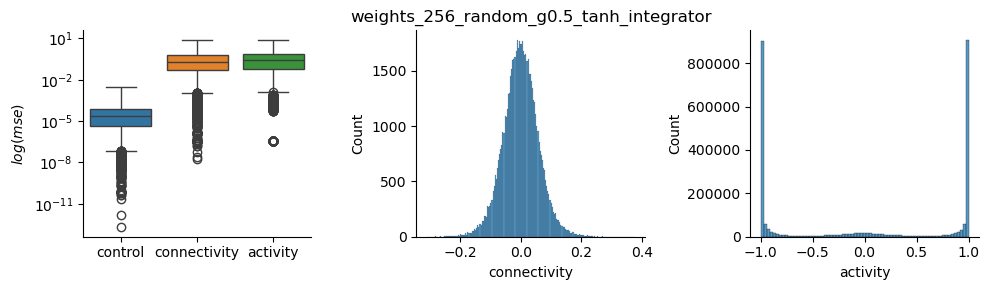

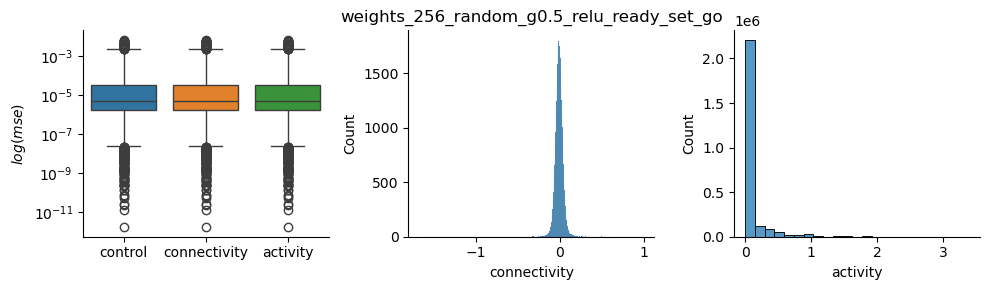

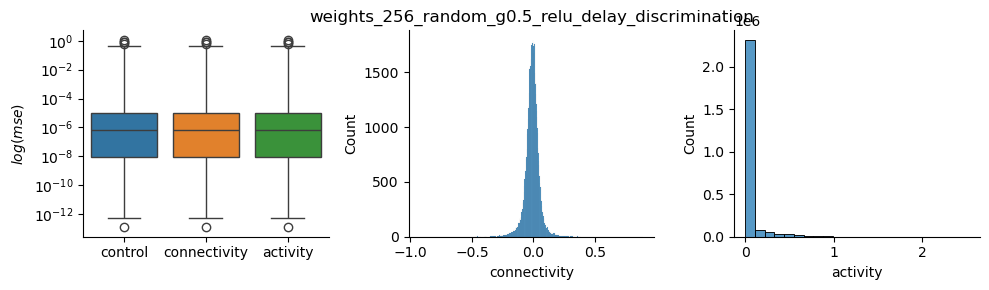

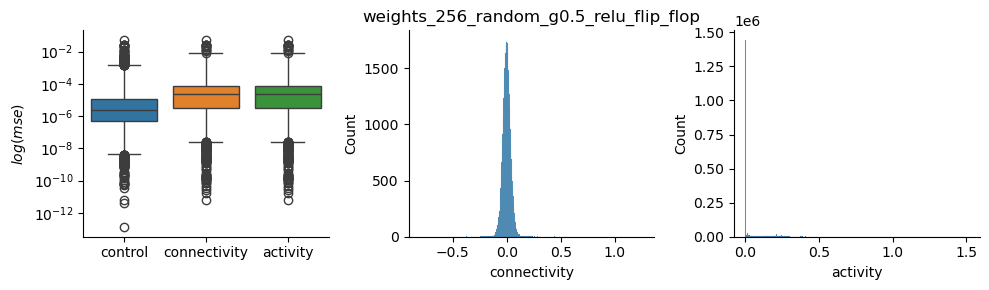

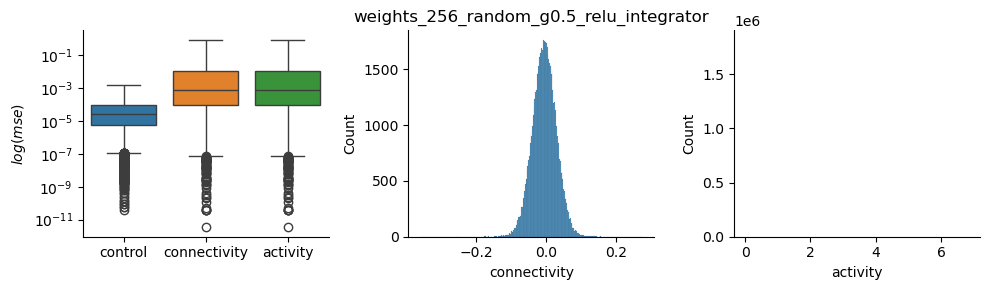

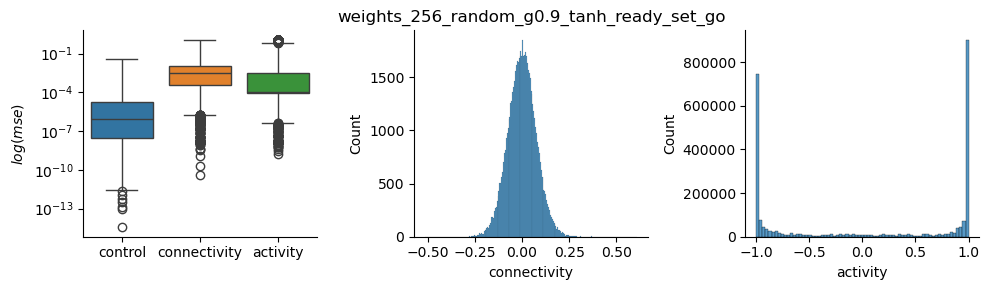

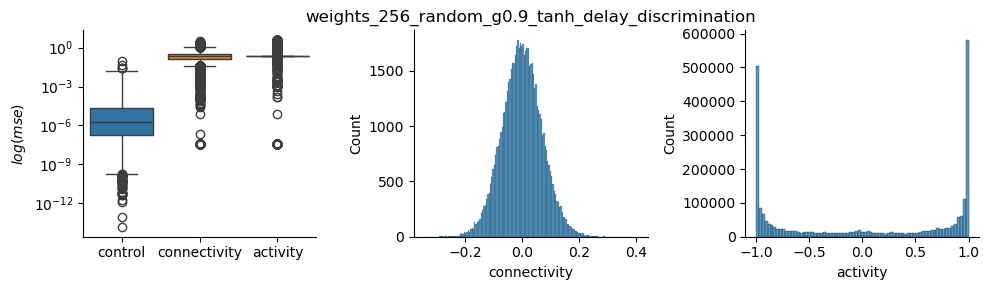

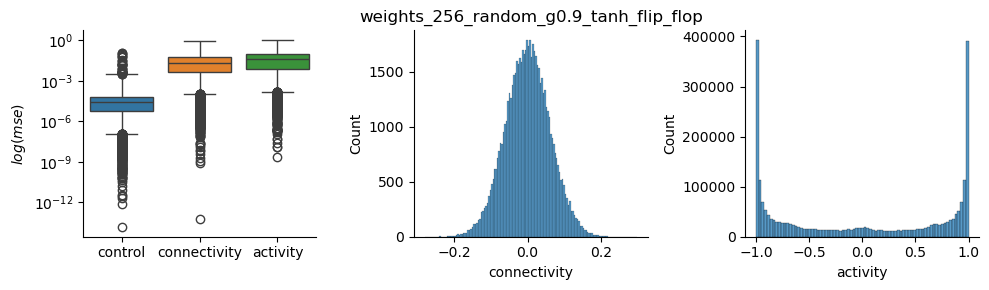

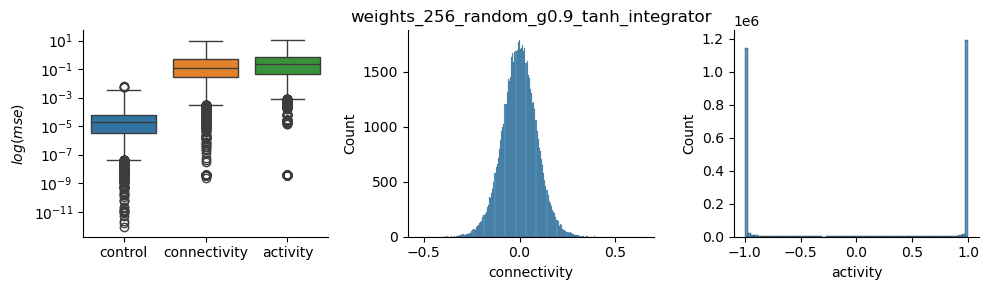

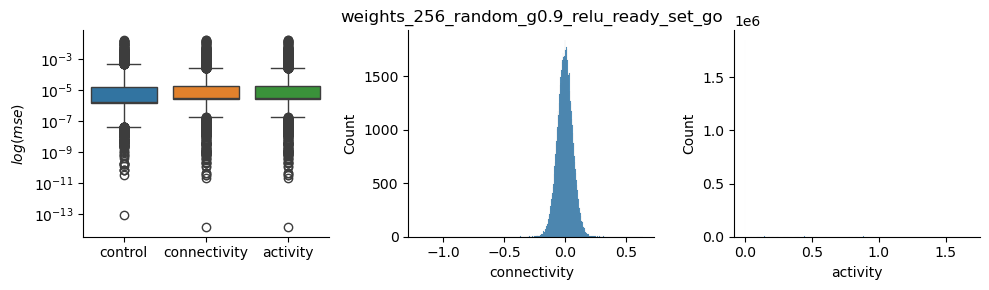

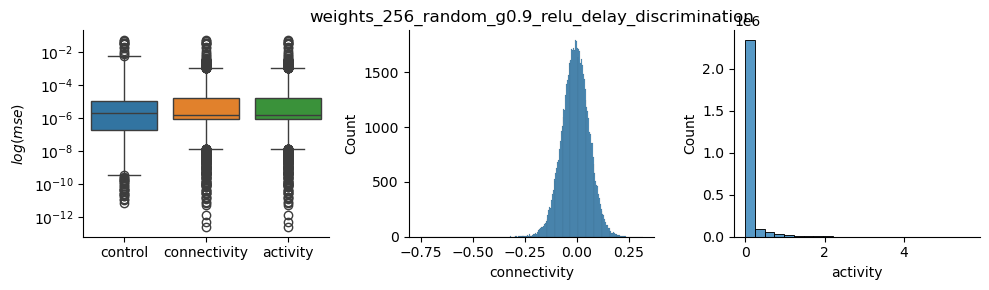

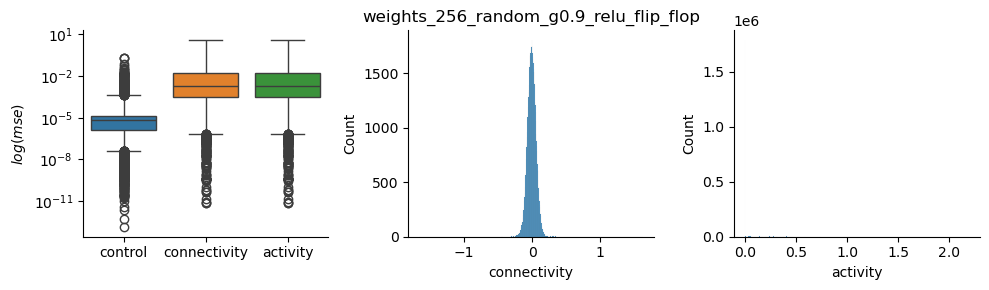

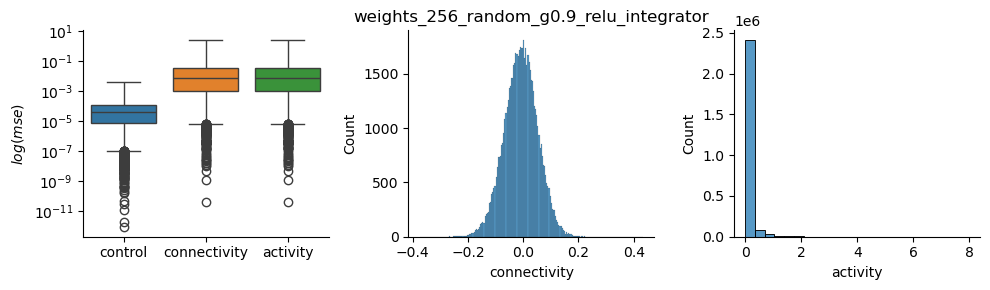

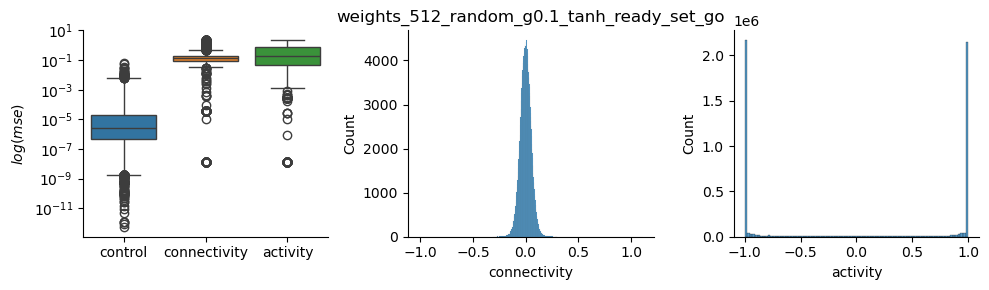

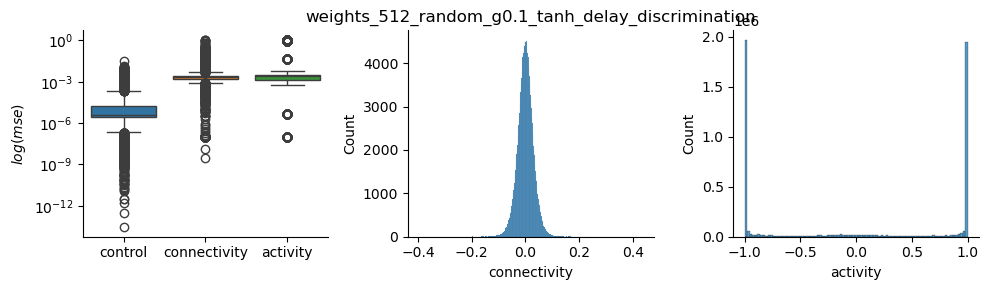

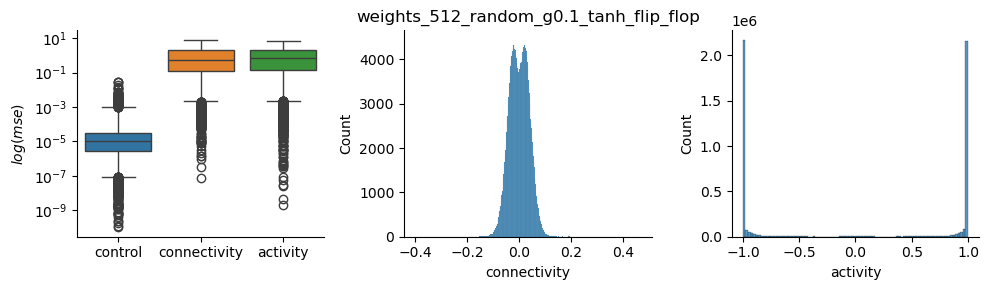

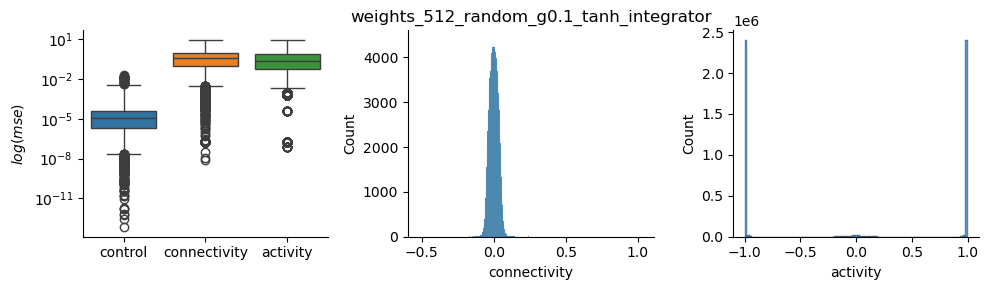

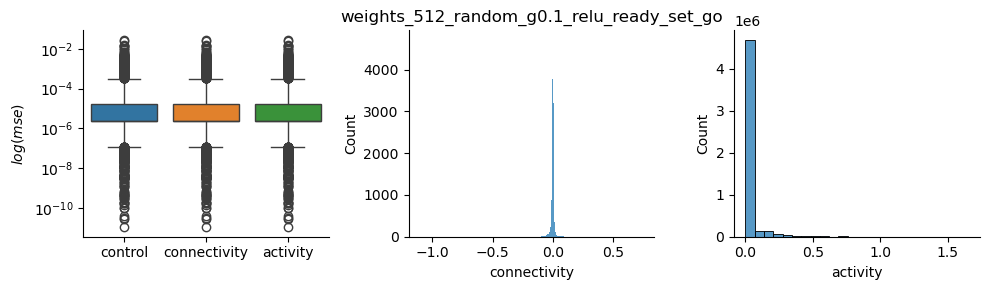

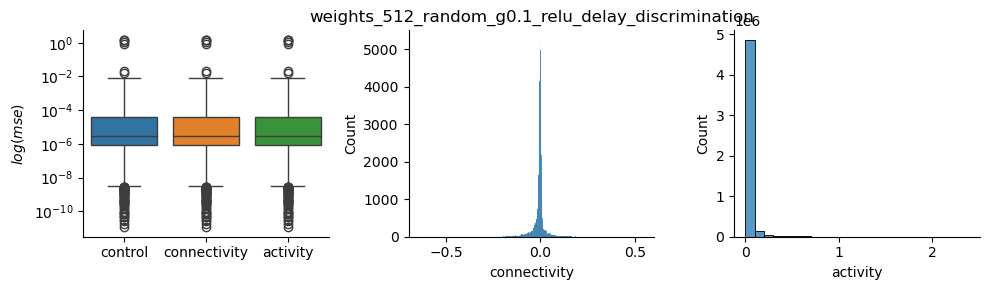

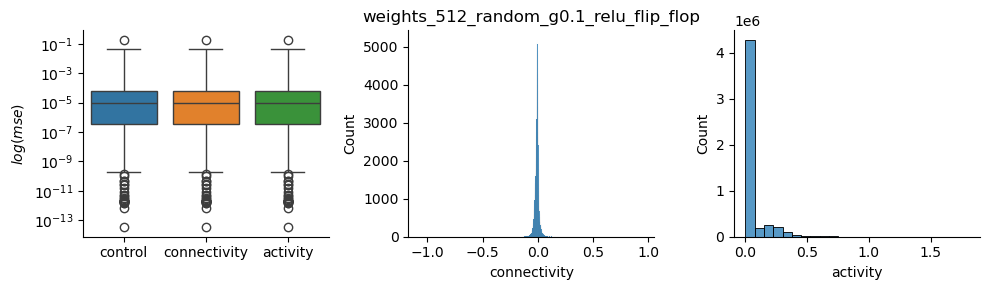

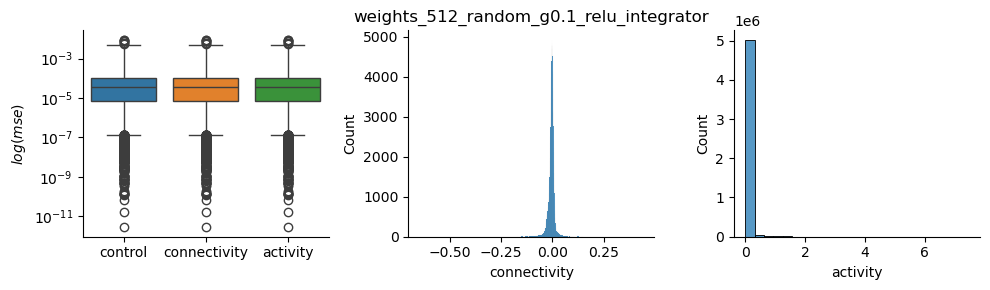

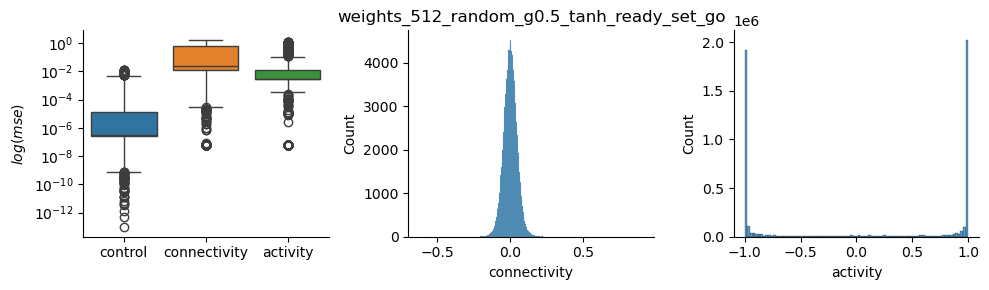

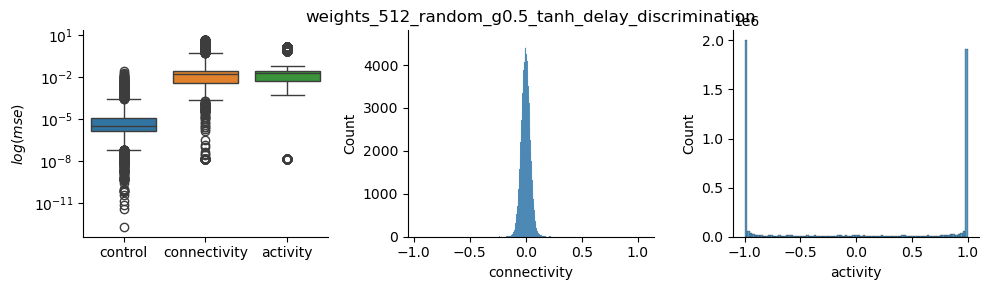

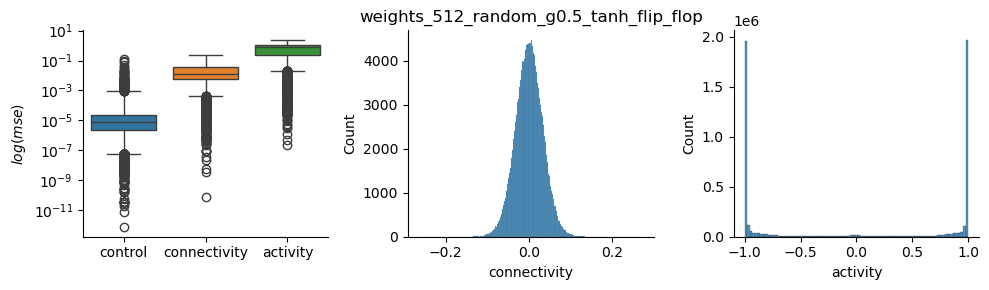

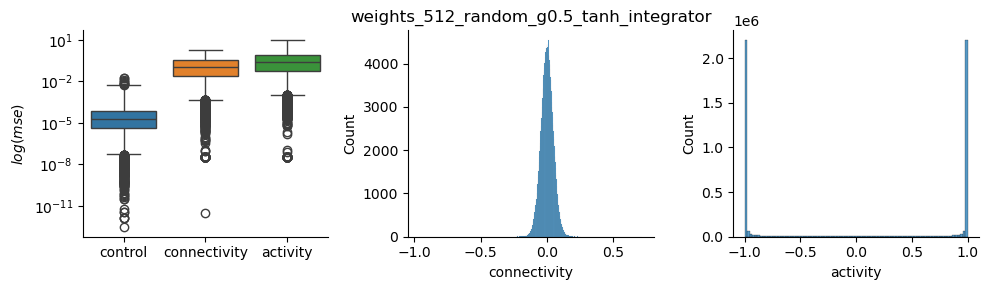

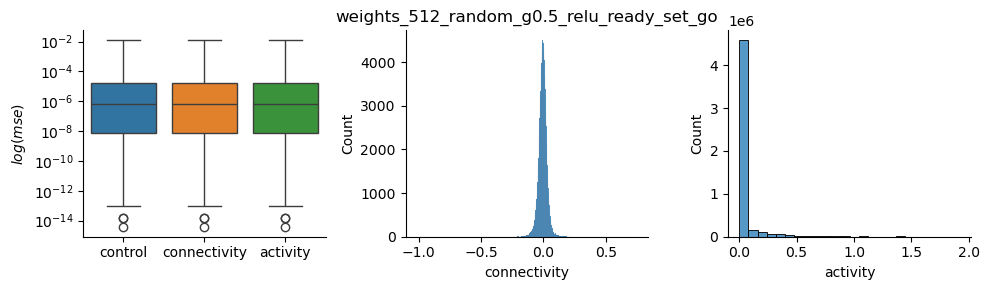

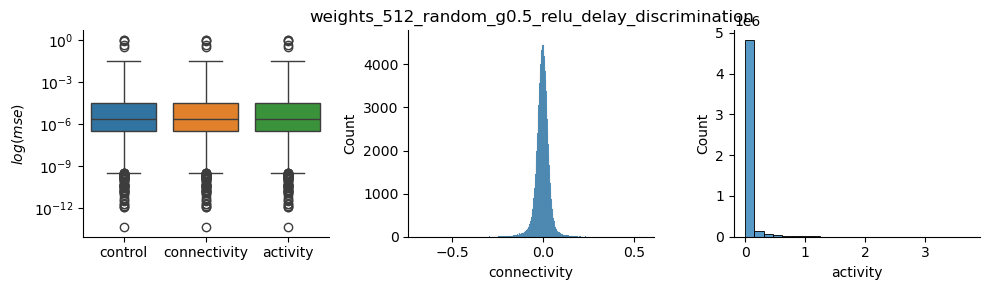

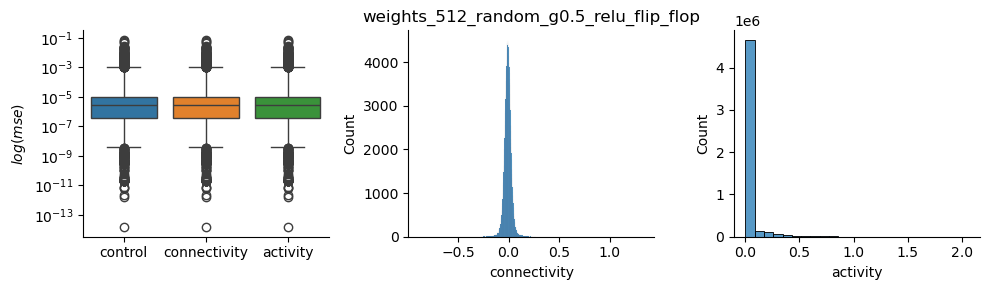

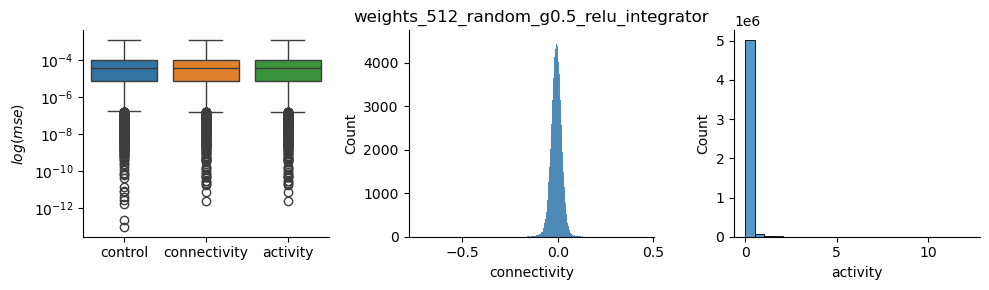

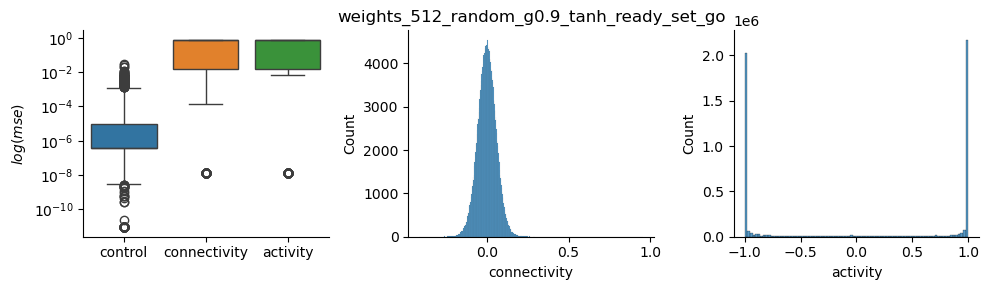

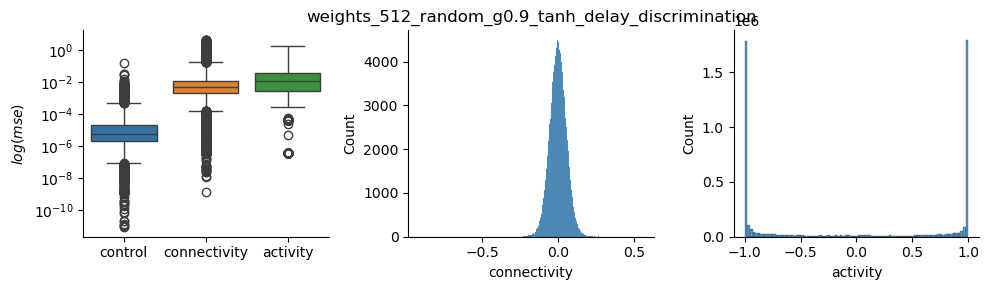

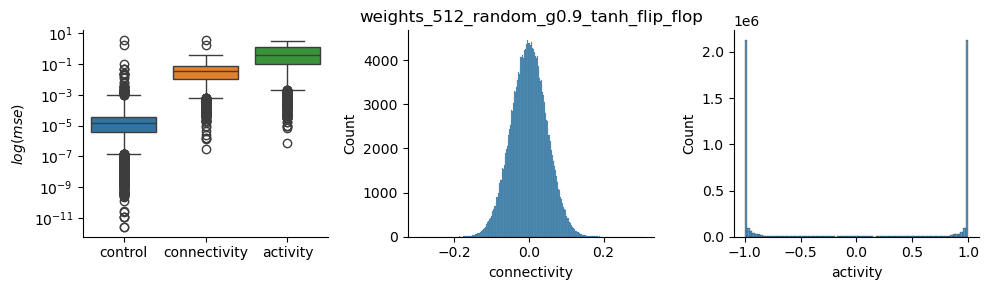

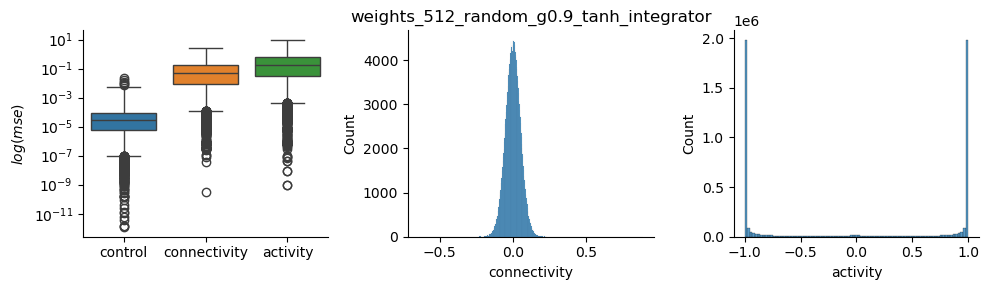

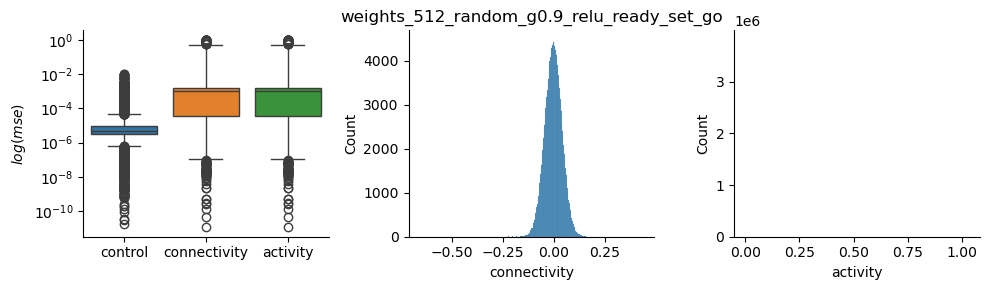

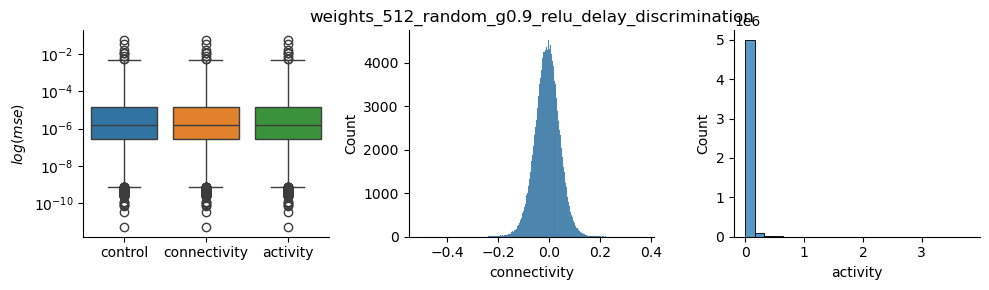

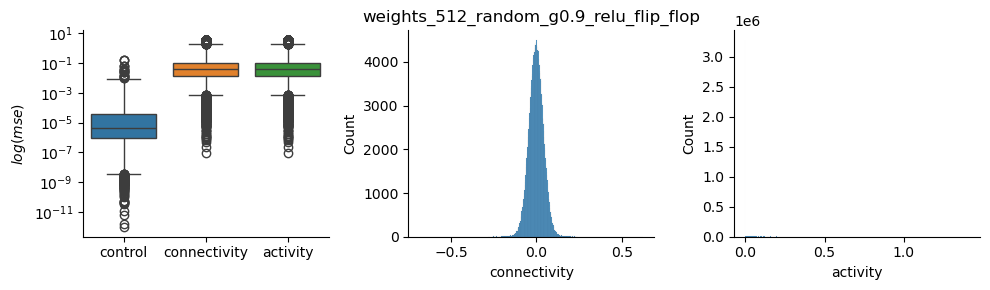

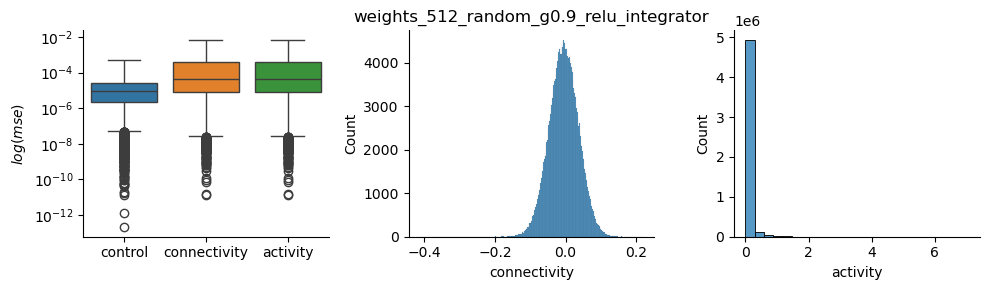

In [3]:
for hidden_dim in hidden_dims:
    for init_type in initialization_types:
        for g in g_values:
            for nonlinearity in nonlinearities:
                for task in tasks:

                    num_silenced = int(hidden_dim * percentage_silenced)

                    # Append task-specific values to dictionary
                    dic['hidden'].append(hidden_dim)
                    dic['g'].append(g)
                    dic['phi'].append(nonlinearity)
                    dic['task'].append(task.split('_')[-1])

                    # Dataset preparation
                    task_dataset = RNNTaskDataset(n_trials=100, time=100, n_channels=2)
                    x, y = getattr(task_dataset, task)()
                    x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
                    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

                    # Initialize models
                    model_params = {
                        'input_dim': x.shape[2],
                        'hidden_dim': hidden_dim,
                        'output_dim': y.shape[2],
                        'nonlinearity': nonlinearity,
                        'initialize_uniform': (init_type == "uniform"),
                        'initialize_normal': (init_type == "random"),
                        'g': g
                    }
                    model = MyRNN(**model_params).to(device)
                    model_lesion = MyRNN(**model_params).to(device)

                    # Load weights
                    weights_path = os.path.join('rnn_weights_2/', f"weights_{hidden_dim}_{init_type}_g{g}_{nonlinearity}_{task}.pt")
                    if not os.path.exists(weights_path):
                        weights_path = os.path.join('rnn_weights_2/', f"best_failed_weights_{hidden_dim}_{init_type}_g{g}_{nonlinearity}_{task}.pt")

                    model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
                    model_lesion.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))

                    # Plotting setup
                    if plot:
                        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

                    # Weight matrix and connectivity standard deviation
                    weight_matrix = model.rnn.weight_hh_l0.detach().numpy()
                    dic['connectivity_std'].append(weight_matrix.std())

                    # Plot connectivity histogram
                    if plot:
                        ax2.set_title(f"weights_{hidden_dim}_{init_type}_g{g}_{nonlinearity}_{task}")
                        sns.histplot(ax=ax2, data=weight_matrix.flatten())
                        ax2.set_xlabel('connectivity')

                    # Neuron selection based on connectivity
                    ko_neurons_connectivity = np.argsort(np.abs(weight_matrix).mean(axis=0) + np.abs(weight_matrix).mean(axis=1))
                    ko_neurons_connectivity = ko_neurons_connectivity[:num_silenced] if low else ko_neurons_connectivity[-num_silenced:]

                    # Simulate control (without lesion)
                    all_output, all_hidden = [], []
                    hid = None
                    for i in range(x.shape[1]):
                        out, hid = model(x_tensor[:, i, :].unsqueeze(1), hid)
                        all_output.append(out)
                        all_hidden.append(hid)

                    # Plot activity histogram
                    if plot:
                        sns.histplot(ax=ax3, data=torch.stack(all_hidden).flatten().detach().numpy())
                        ax3.set_xlabel('activity')
                    dic['activity_std'].append(torch.stack(all_hidden).flatten().detach().numpy().std())

                    # Neuron selection based on activity
                    all_hidden = torch.hstack(all_hidden).squeeze().detach().numpy()
                    ko_neurons_activity = np.argsort(np.abs(all_hidden).mean(axis=0))
                    ko_neurons_activity = ko_neurons_activity[:num_silenced] if low else ko_neurons_activity[-num_silenced:]

                    # Control MSE calculation
                    control_mean_mse, control_mean_by_hand, control_std_mse, control_raw = criterion_fn(
                        torch.hstack(all_output).squeeze().reshape(100, 100, y_tensor.size(2)), y_tensor
                    )
                    assert control_mean_mse == control_mean_by_hand
                    dic['mse_control'].append(control_mean_mse.item())
                    dic['std_control'].append(control_std_mse.item())

                    # Zero out neurons based on connectivity and reassign the weight matrix
                    for neuron in ko_neurons_connectivity:
                        weight_matrix[neuron, :] = 0
                        weight_matrix[:, neuron] = 0
                    model_lesion.rnn.weight_hh_l0.data = torch.tensor(weight_matrix)

                    # Simulate lesion based on connectivity
                    all_output, all_hidden = [], []
                    hid = None
                    for i in range(x.shape[1]):
                        # out, hid = model(x_tensor[:, i, :].unsqueeze(1), hid)
                        # for neuron_idx in ko_neurons_connectivity:
                        #     hid[0, :, neuron_idx] = 0  # Lesion neurons in hidden state
                            
                        out, hid = model_lesion(x_tensor[:, i, :].unsqueeze(1), hid)
                        
                        all_output.append(out)
                        all_hidden.append(hid)

                    # MSE after connectivity lesion
                    connectivity_mean_mse, connectivity_mean_by_hand, connectivity_std_mse, connectivity_raw = criterion_fn(
                        torch.hstack(all_output).squeeze().reshape(100, 100, y_tensor.size(2)), y_tensor
                    )
                    assert connectivity_mean_mse == connectivity_mean_by_hand
                    dic['mse_lesion_connectivity'].append(connectivity_mean_mse.item())
                    dic['std_lesion_connectivity'].append(connectivity_std_mse.item())

                    # Simulate lesion based on activity
                    all_output, all_hidden = [], []
                    hid = None
                    for i in range(x.shape[1]):
                        out, hid = model(x_tensor[:, i, :].unsqueeze(1), hid)
                        for neuron_idx in ko_neurons_activity:
                            hid[0, :, neuron_idx] = 0  # Lesion neurons in hidden state
                        all_output.append(out)
                        all_hidden.append(hid)

                    # MSE after activity lesion
                    activity_mean_mse, activity_mean_by_hand, activity_std_mse, activity_raw = criterion_fn(
                        torch.hstack(all_output).squeeze().reshape(100, 100, y_tensor.size(2)), y_tensor
                    )
                    assert activity_mean_mse == activity_mean_by_hand
                    dic['mse_lesion_activity'].append(activity_mean_mse.item())
                    dic['std_lesion_activity'].append(activity_std_mse.item())

                    # Save results to DataFrame and plot if required
                    data = pd.DataFrame({
                        'control': control_raw.detach().numpy(),
                        'connectivity': connectivity_raw.detach().numpy(),
                        'activity': activity_raw.detach().numpy()
                    })

                    if plot:
                        sns.boxplot(ax=ax1, data=data, log_scale=True)
                        ax1.set_ylabel(f'$log(mse)$')
                        sns.despine()
                        plt.tight_layout()
                        plt.show()


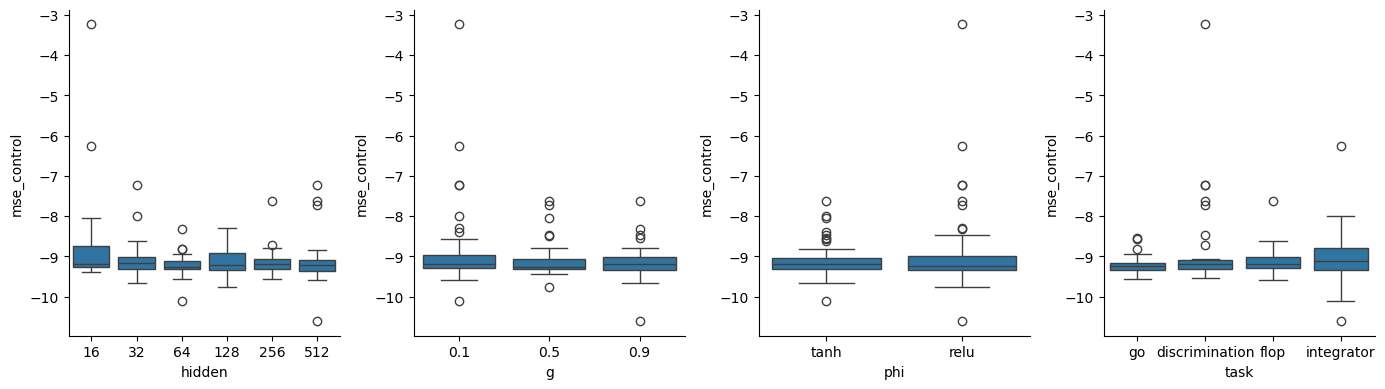

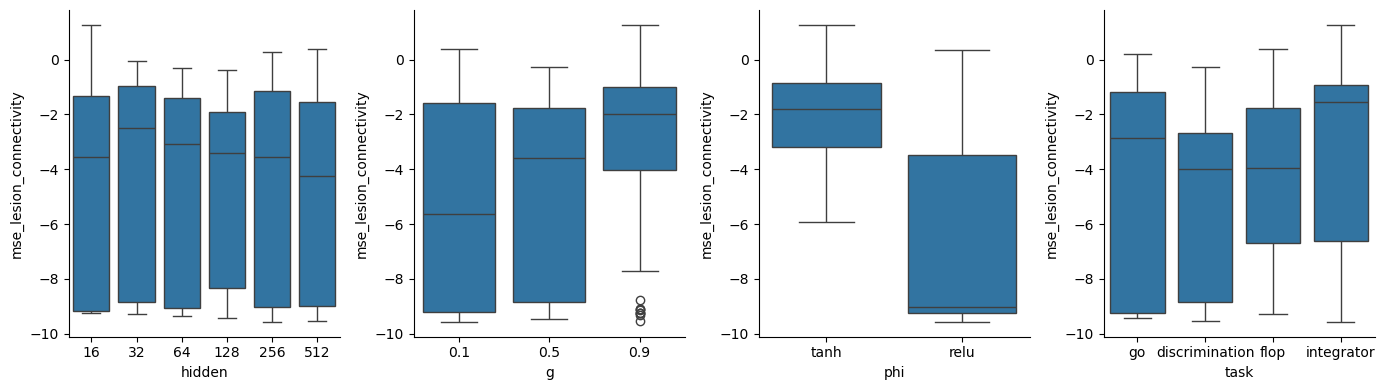

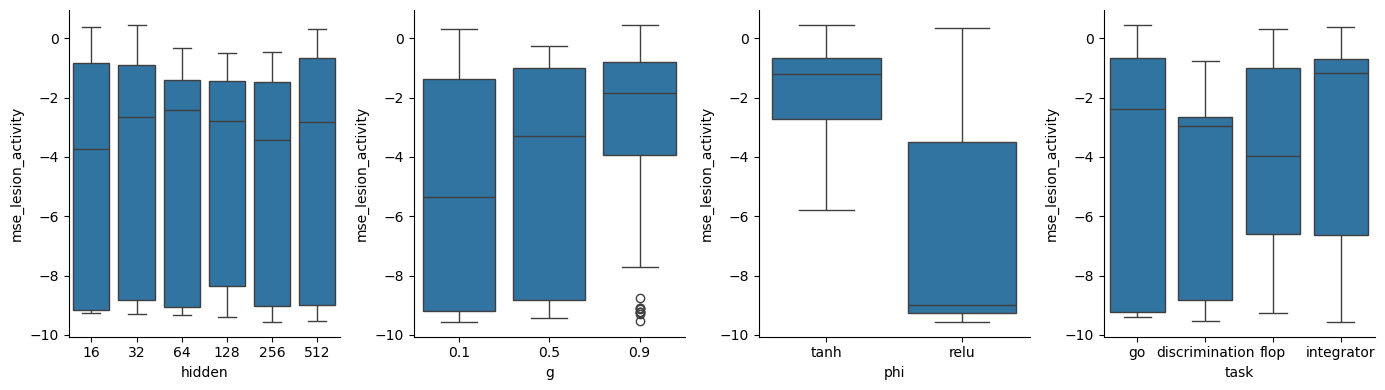

In [4]:
df = pd.DataFrame(dic)
df[['mse_control', 'std_control', 
    'mse_lesion_connectivity', 'std_lesion_connectivity',
    'mse_lesion_activity','std_lesion_activity']] = np.log(df[['mse_control', 'std_control', 
    'mse_lesion_connectivity', 'std_lesion_connectivity',
    'mse_lesion_activity','std_lesion_activity']])

fig,ax = plt.subplots(1,4,figsize=(14,4))
n = df.columns[:4]
for i in range(4):
    sns.boxplot(ax=ax[i],data=df,x=n[i],y='mse_control')

sns.despine()
plt.tight_layout()
plt.show()


fig,ax = plt.subplots(1,4,figsize=(14,4))
n = df.columns[:4]
for i in range(4):
    sns.boxplot(ax=ax[i],data=df,x=n[i],y='mse_lesion_connectivity')

sns.despine()
plt.tight_layout()
plt.show()

fig,ax = plt.subplots(1,4,figsize=(14,4))
n = df.columns[:4]
for i in range(4):
    sns.boxplot(ax=ax[i],data=df,x=n[i],y='mse_lesion_activity')

sns.despine()
plt.tight_layout()
plt.show()

df['phi'] = df['phi'].astype("category")
df['task'] = df['task'].astype("category")

# df['phi'] = df['phi'].cat.codes
# df['task'] = df['task'].cat.codes
                                              

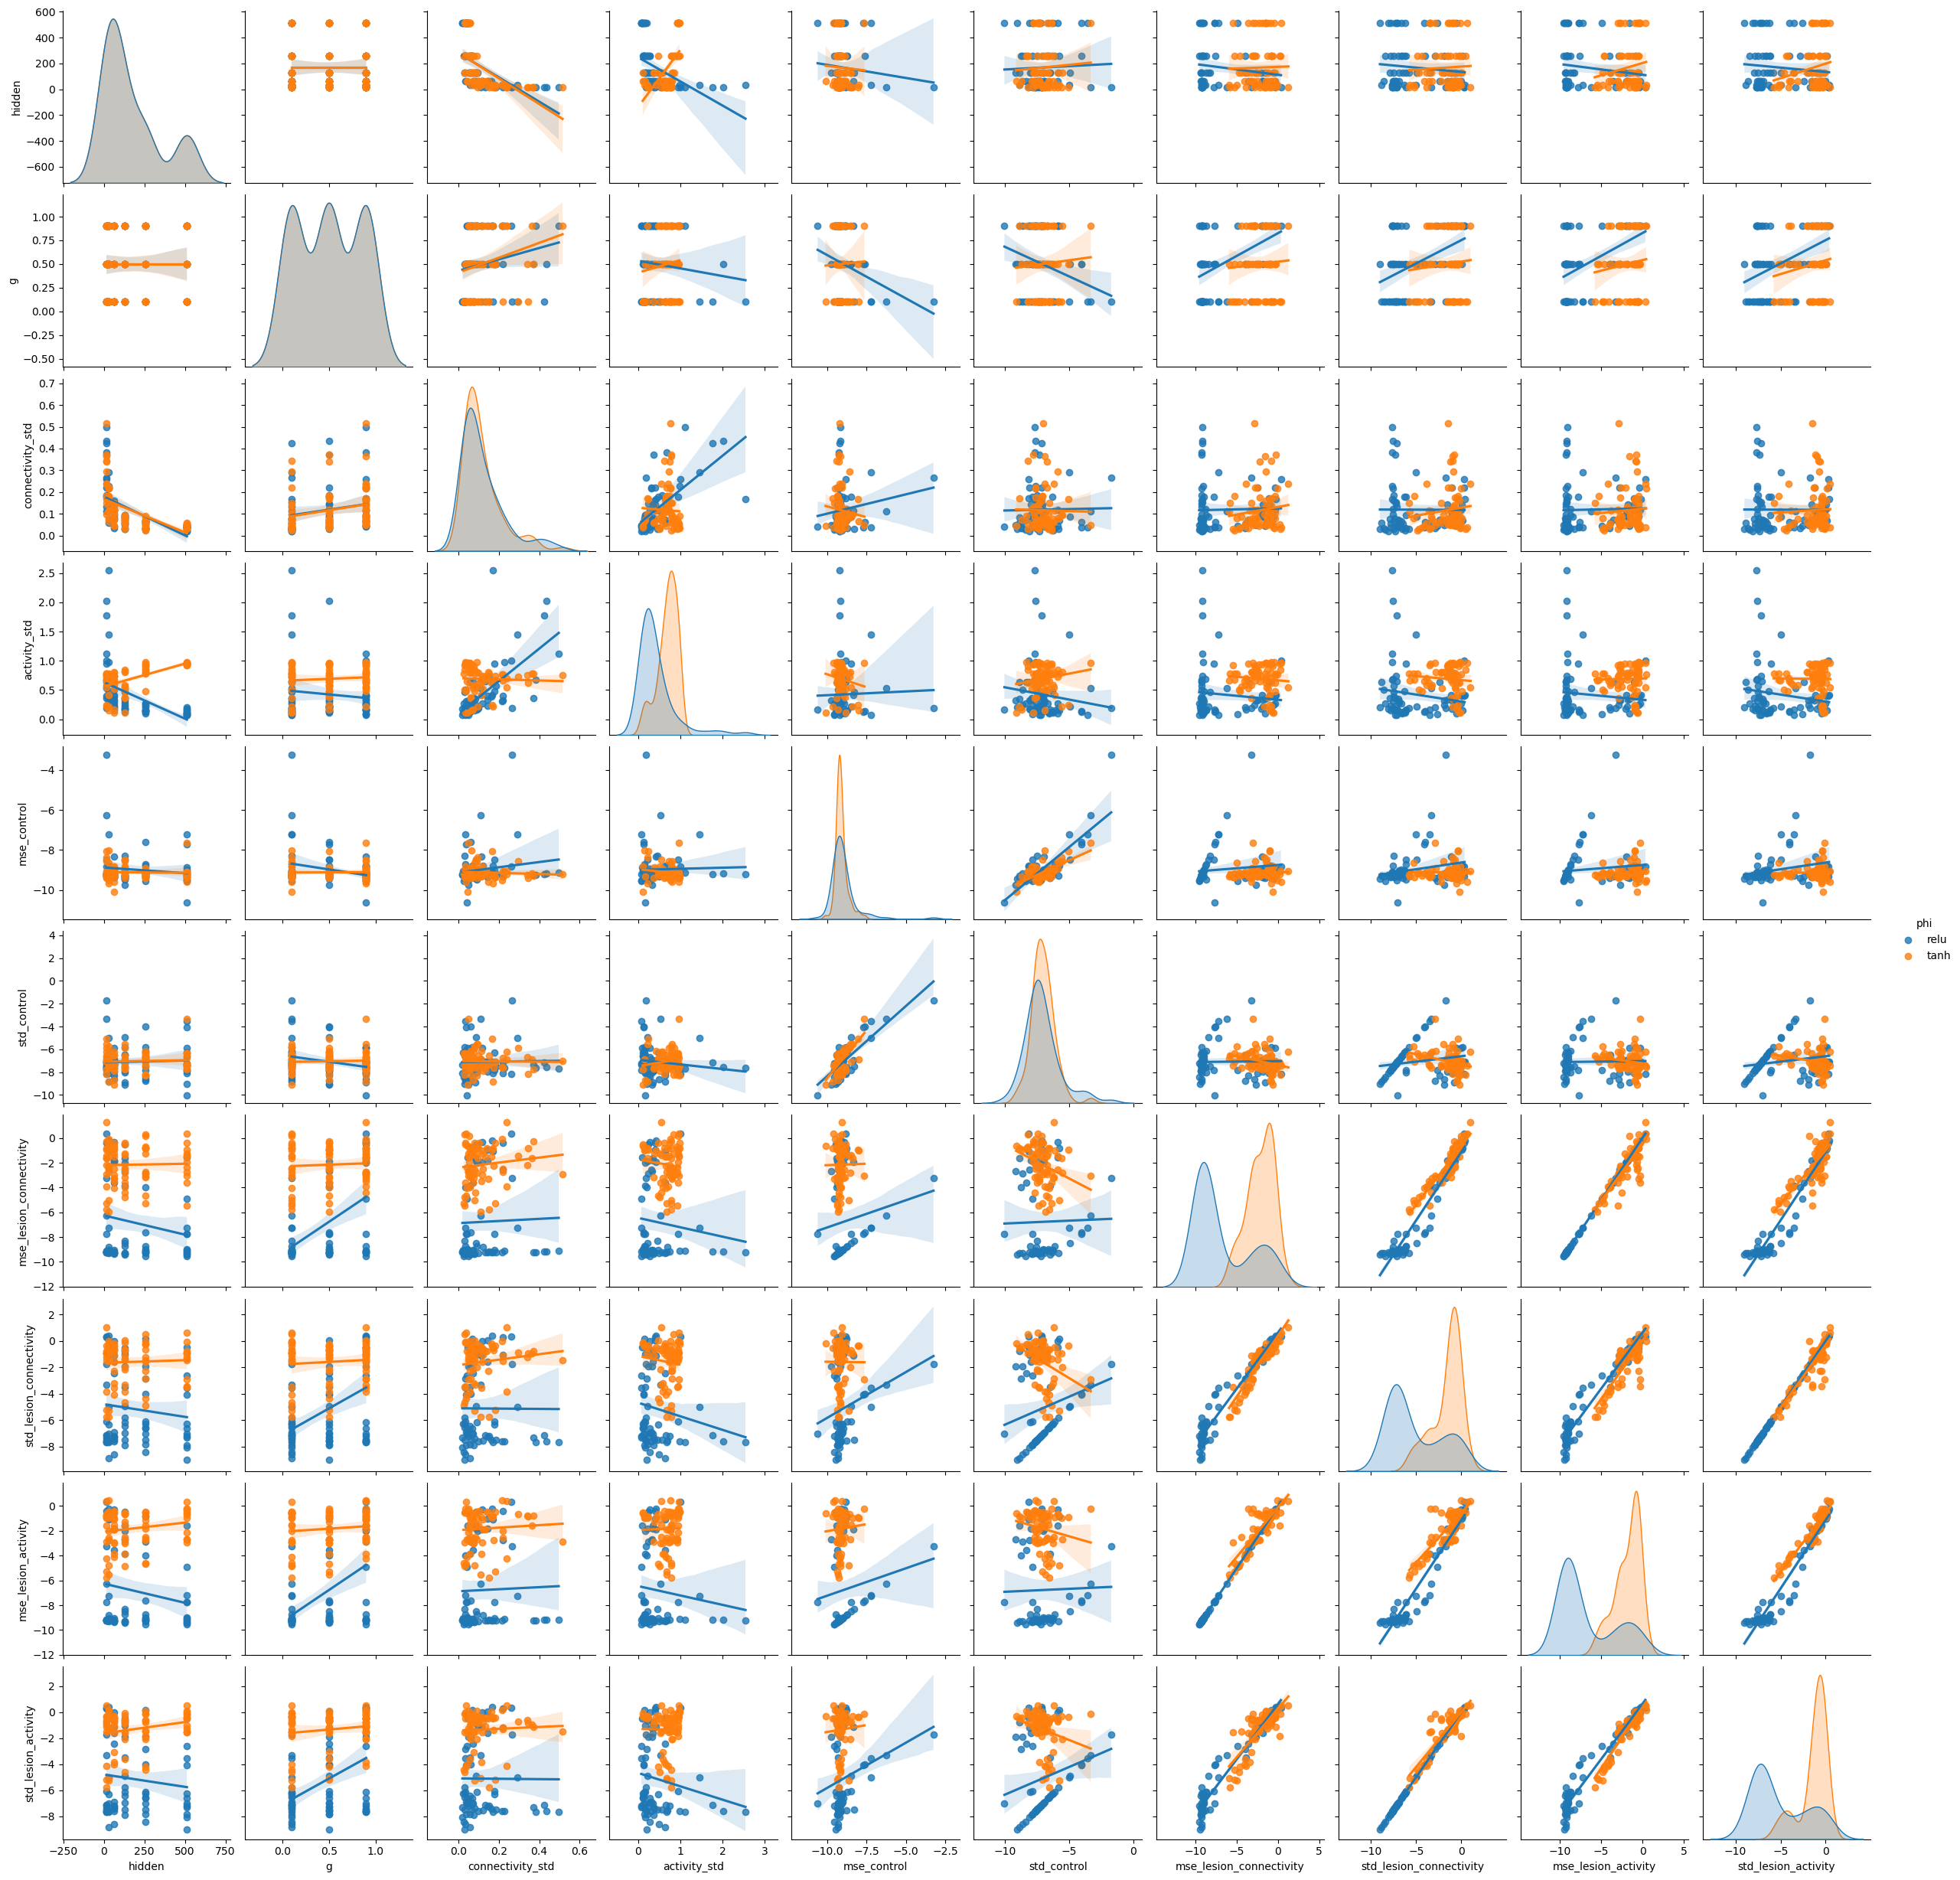

In [5]:
sns.pairplot(df, corner=True, kind='reg', hue='phi', palette='tab10',) 